In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import os
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats

In [2]:
def add_smoothed_pseudotime(path_to_adata):
    adata = sc.read(path_to_adata) 
    adata.obsm['X_spatial'] = adata.obs[['x', 'y']].values

    knn = NearestNeighbors(n_neighbors=50)
    knn.fit(adata.obsm['X_spatial'])
    pseud_array = np.array(adata.obs['pseudotime'].tolist())

    smoothed_pseudotime = []
    for ne in range(len(adata.obsm['X_spatial'])):
        smoothed_pseudotime.append(np.mean(pseud_array[knn.kneighbors(np.array([adata.obsm['X_spatial'][ne]]), return_distance=False)]))
    adata.obs['smoothed_pseudotime'] = smoothed_pseudotime

    return adata


def get_pseudotime_nearest(adata, targets, arrangement):
    qdata = adata[~adata.obs['bacterial'].isin(targets)] # Cell types to calculate depth for
    qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
    tdata = adata[adata.obs['bacterial'].isin(targets)] # Cell types to use for depth calculation
    all_pseudotimes = []
    for nneigh in arrangement:
        nn = NearestNeighbors(n_jobs=32)
        nn.fit(qdata.obsm['X_spatial'])
        dist, _ = nn.kneighbors(tdata.obsm['X_spatial'], n_neighbors=nneigh)
        smoothed_pseudotimes = []
        for i in _:
            smoothed_pseudotimes.append(np.mean(qdata[i,:].obs['smoothed_pseudotime'].tolist()))
        all_pseudotimes.append(smoothed_pseudotimes)
    all_pseudotimes = np.array(all_pseudotimes)
    return all_pseudotimes, tdata.obs.bac_spots.tolist()

def weighted_std(values, weights, axis=None):
    """
    Calculate the weighted standard deviation along the specified axis.
    
    Parameters:
    values : array_like
        The values for which to calculate the weighted standard deviation.
    weights : array_like
        The weights for each value.
    axis : int, optional
        Axis along which to calculate the weighted standard deviation.
        
    Returns:
    ndarray
        The weighted standard deviation.
    """
    average = np.average(values, weights=weights, axis=axis)
    variance = np.average((values - np.expand_dims(average, axis=axis))**2, weights=weights, axis=axis)
    return np.sqrt(variance)


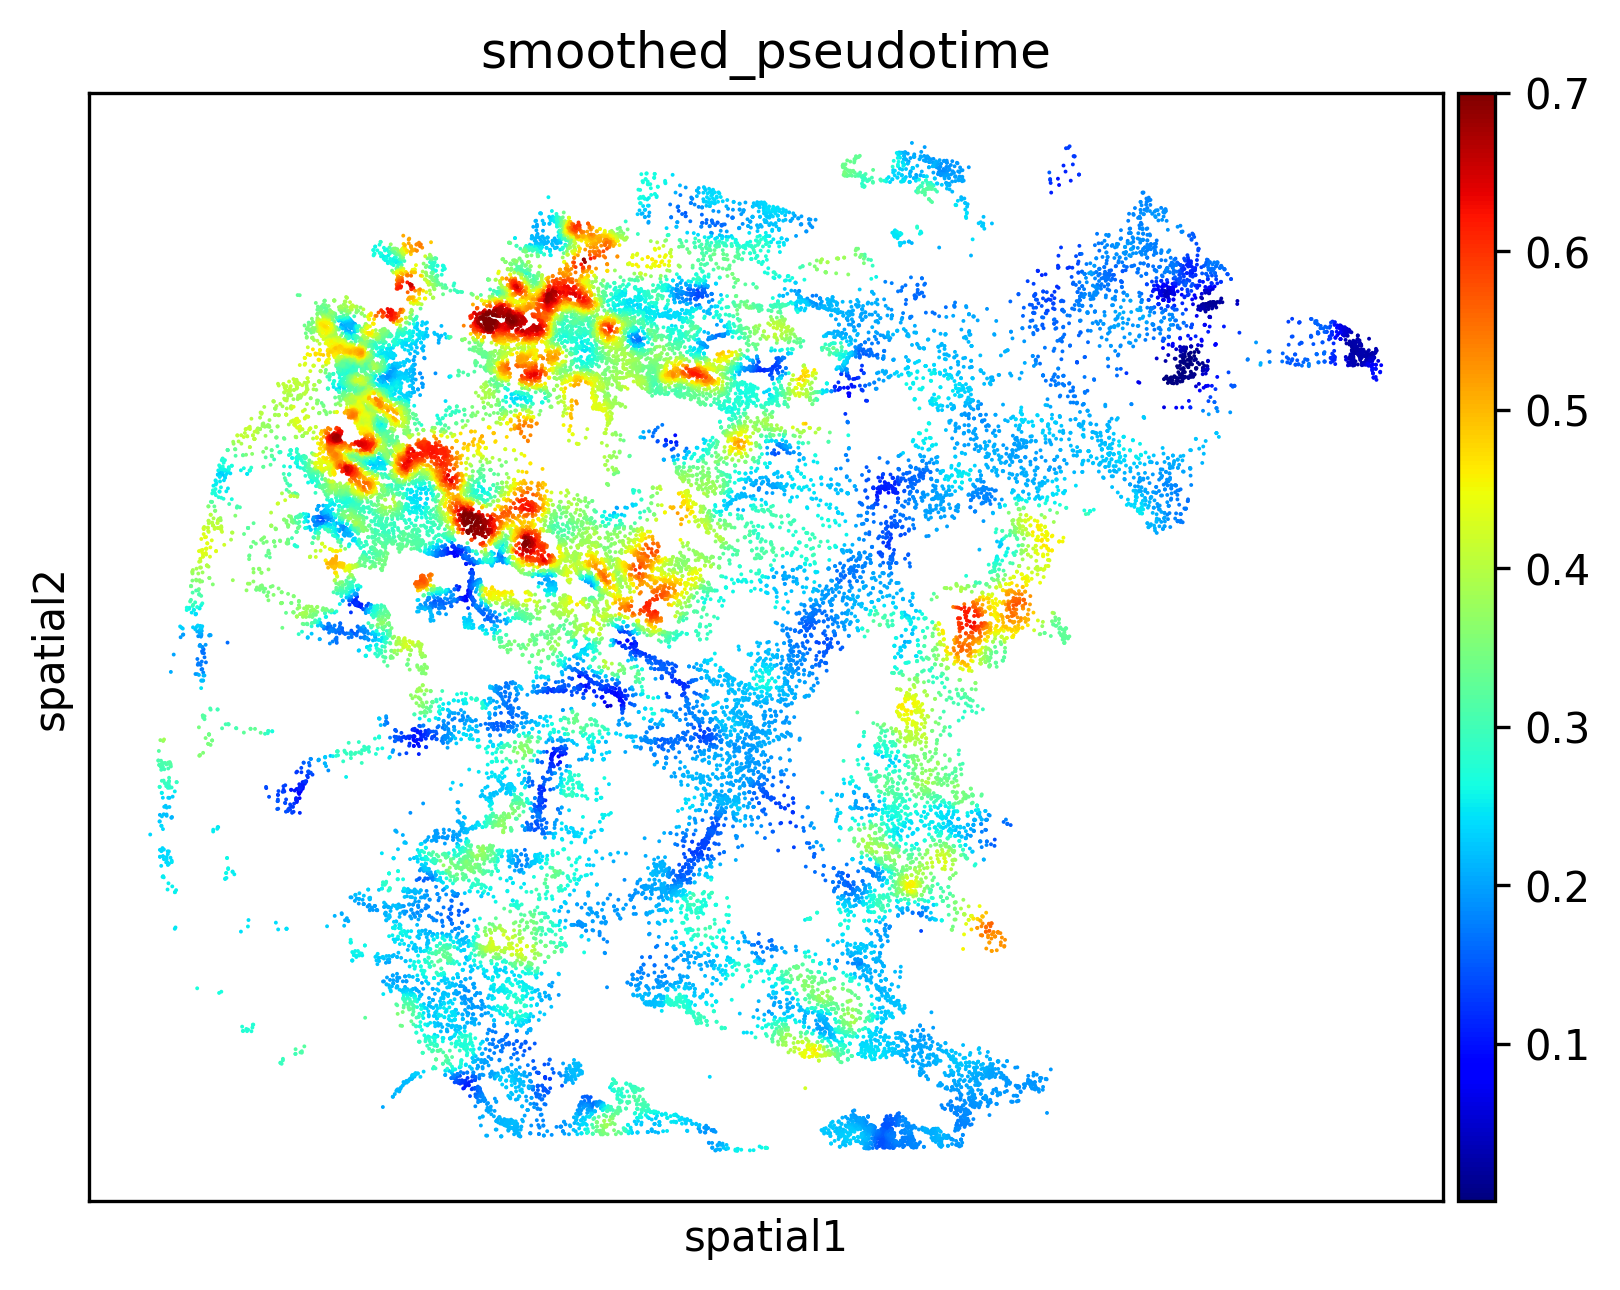

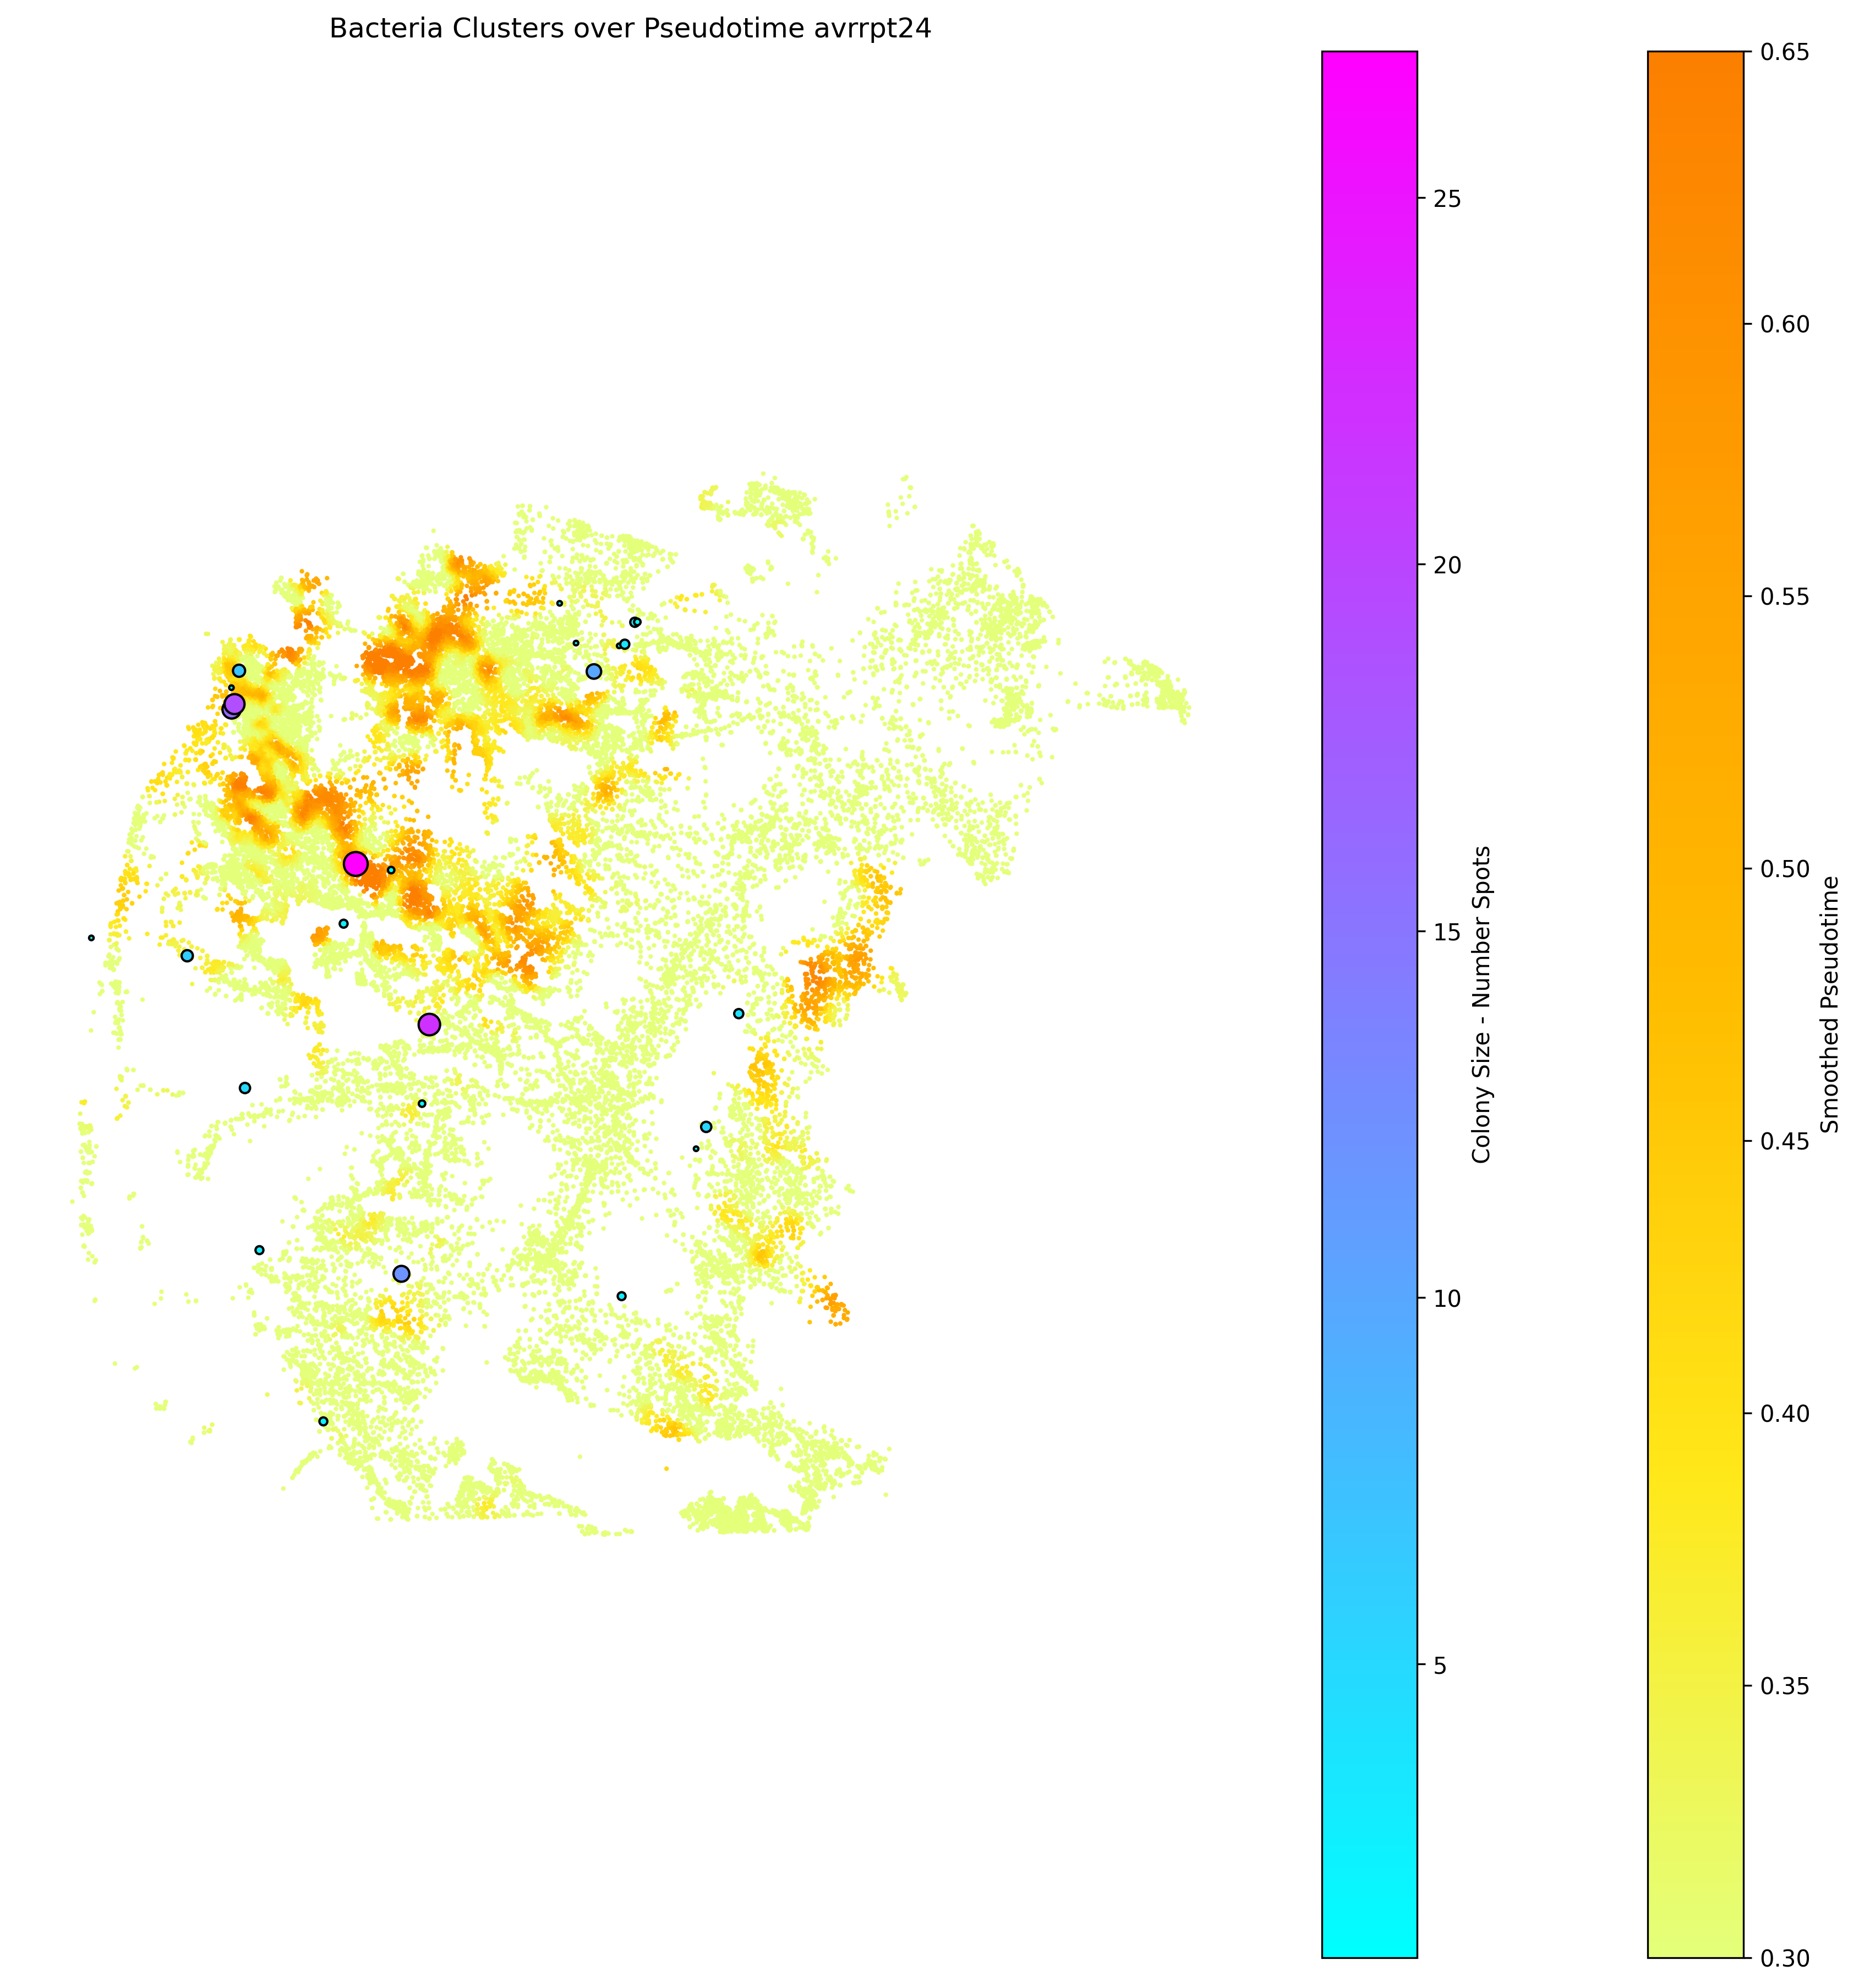

/home/amonell/mambaforge/envs/merscope_01/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attrib

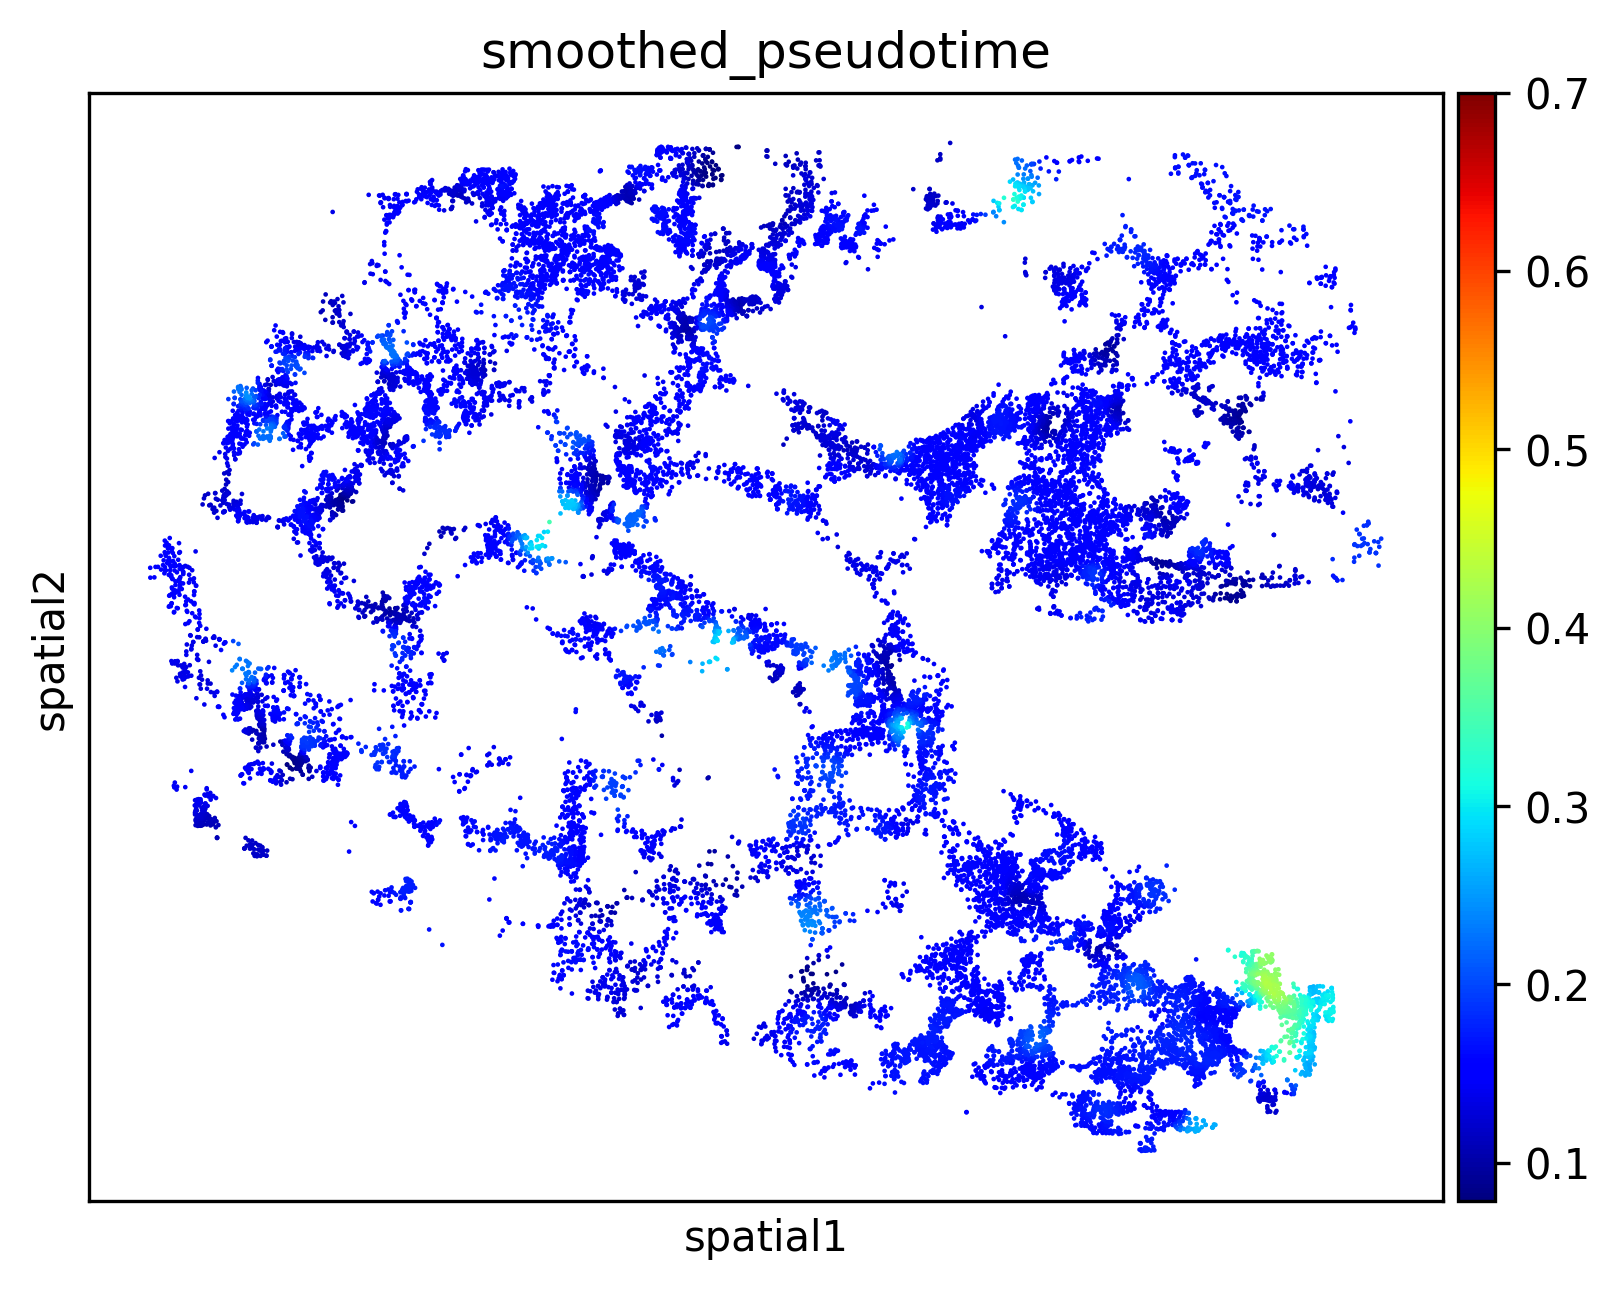

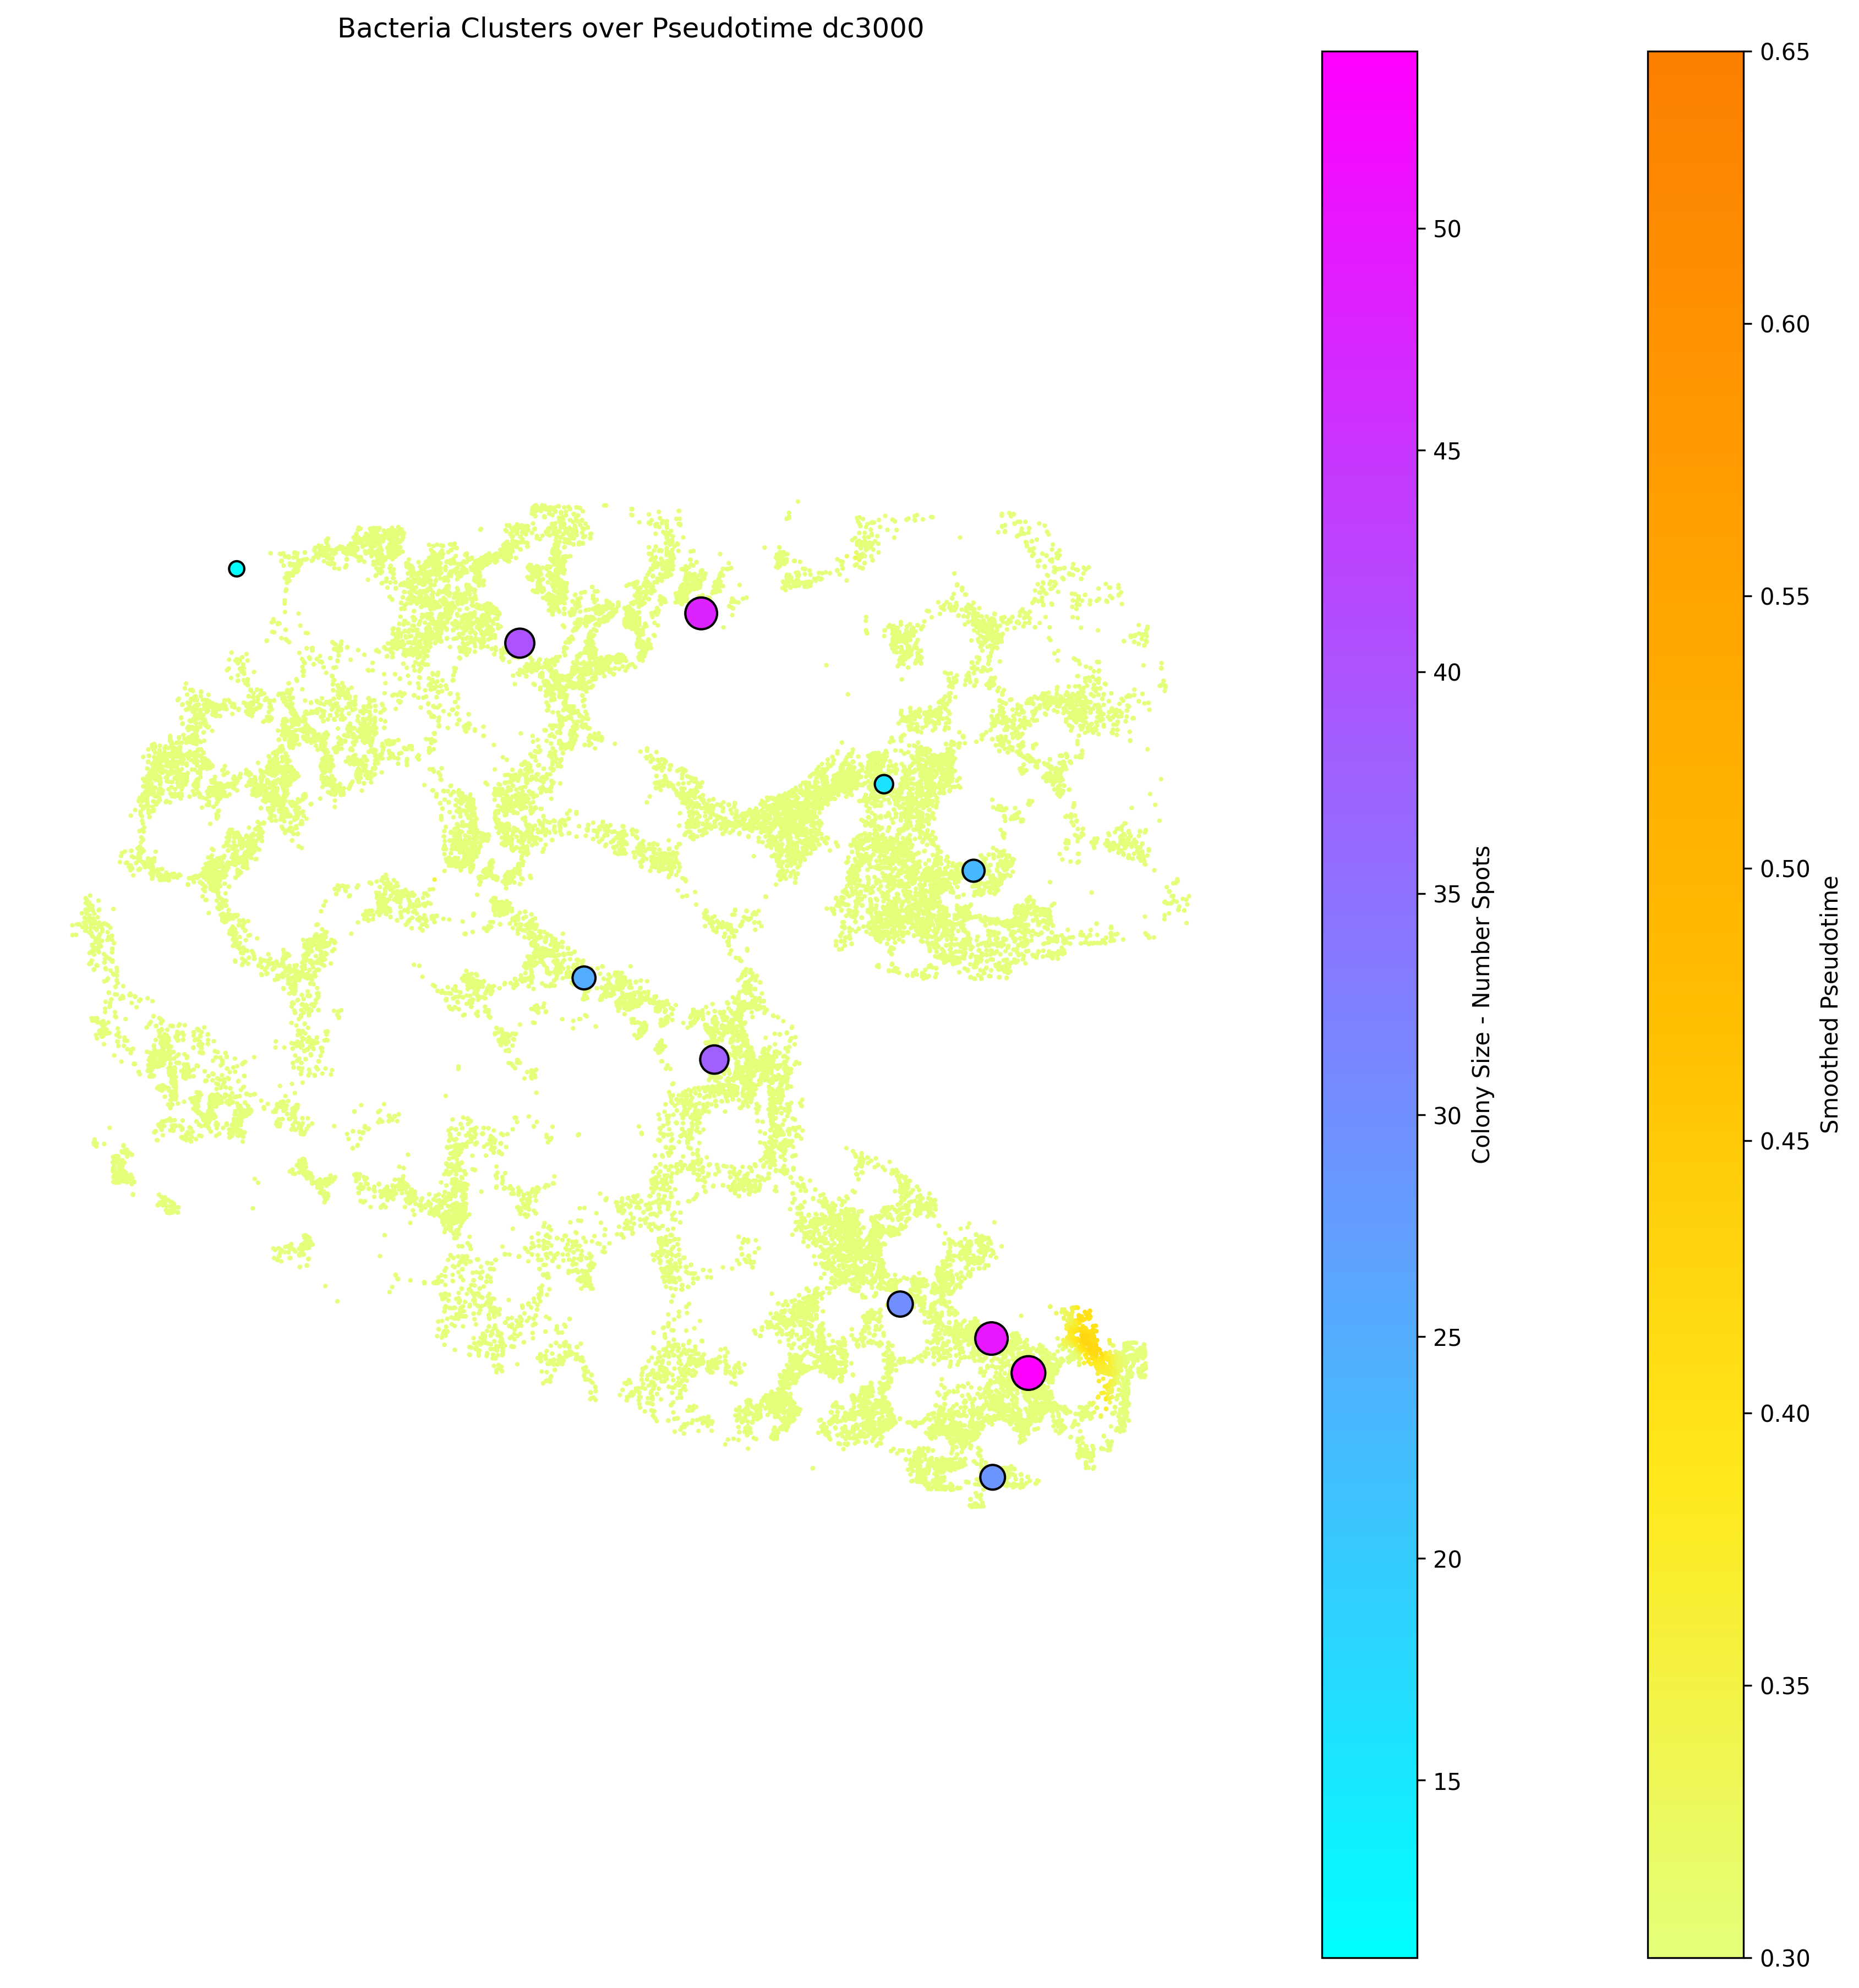

/home/amonell/mambaforge/envs/merscope_01/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/amonell/mambaforge/envs/merscope_01/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  qdata.obs['zscored_pseudo'] = stats.zscore(qdata.obs['smoothed_pseudotime'].values)
/tmp/ipykernel_895105/410407113.py:19: ImplicitModificationWarning: Trying to mo

In [23]:
samples = ['avrrpt24', 'dc3000']
mean_pseudo_weighted_by_clustersize = []
std_pseudo_weighted_by_clustersize = []

k5_pseudo = []
k5_cluster = []

all_pseudo = []
all_cluster = []
for sample in samples:
    path_to_adata = os.path.join('../../data/integration', sample, 'spatial_data.h5ad')
    path_to_bacteria_spots = os.path.join(rf'{sample}', 'centroids_final_spots.npy')
    adata = add_smoothed_pseudotime(path_to_adata)

    #### Plotting the smoothed pseudotime as a proxy for spatial immune hotspots
    fig, axes = plt.subplots(1,1)
    fig.dpi = 300
    axes = sc.pl.embedding(adata, basis = 'spatial', color = 'smoothed_pseudotime', cmap = 'jet', show = False, ax = axes, vmax = 0.7)
    plt.show()
    fig.savefig(os.path.join(sample, 'smoothed_pseudotime.pdf'))
    plt.close()

    #### Plotting bacterial colonies over the sample

    bacteria = np.load(path_to_bacteria_spots)
    bacteria_adata = ad.AnnData(X = np.zeros((len(bacteria), len(adata.var))), var=adata.var, obs = ['bacteria'+str(i) for i in range(len(bacteria))])
    bacteria_adata.obs.index = bacteria_adata.obs[0]
    bacteria_adata.obs = pd.read_csv(os.path.join(os.path.dirname(path_to_bacteria_spots), 'observations.csv'))
    bacteria_adata.obs = bacteria_adata.obs.drop(['Unnamed: 0'], axis=1)
    bacteria_adata.obs['bac_spots'] = bacteria_adata.obs['total_spots_in_colony'] - bacteria_adata.obs['number_hrpl'] - bacteria_adata.obs['number_pvds']

    fig, (ax1) = plt.subplots(1, 1, figsize=(15, 15), dpi = 300)
    fig.dpi = 300
    im1 = ax1.scatter(adata.obsm['X_spatial'].T[0], adata.obsm['X_spatial'].T[1], c = adata.obs['smoothed_pseudotime'], cmap = 'Wistia', s = 1, alpha=1, vmin= 0.3, vmax=0.65)
    ax1.set_facecolor('white')
    ax1.set_title(f'Bacteria Clusters over Pseudotime {sample}')
    cb = fig.colorbar(im1, ax=ax1, orientation='vertical')

    im = ax1.scatter(bacteria.T[1], bacteria.T[0], c = bacteria_adata.obs['bac_spots'].tolist(), s = np.array(bacteria_adata.obs['bac_spots'].tolist())*4, cmap = 'cool', linewidths=1, edgecolors='black')
    cb2 = fig.colorbar(im, ax=ax1, orientation='vertical')
    cb2.set_label('Colony Size - Number Spots')
    cb.set_label('Smoothed Pseudotime')
    ax1.axis('off')

    plt.axis('equal')
    plt.show()
    fig.savefig(os.path.join(sample, 'colonies_spatial.pdf'))

    #### adding bacteria locations to the adata

    bacteria_adata.obs['bac_spots'] = bacteria_adata.obs['total_spots_in_colony'] - bacteria_adata.obs['number_hrpl'] - bacteria_adata.obs['number_pvds']
    bacteria_adata.obs = bacteria_adata.obs.fillna(-1)

    bacteria_overlay = sc.concat([adata, bacteria_adata], join='outer')
    bacteria_overlay.obsm['X_spatial'][-len(bacteria):] = np.array([bacteria.T[1], bacteria.T[0]]).T 

    bacterial = []
    for row in bacteria_overlay.obs['median_distance_from_centroid'].tolist():
        if row >= 0:
            bacterial.append('bac')
        else:
            bacterial.append('cell')

    bacteria_overlay.obs['bacterial'] = bacterial

    arrange = np.arange(1, 1000, 50)
    pseudo, clustersize = get_pseudotime_nearest(bacteria_overlay, ['bac'], arrange)

    mean_pseudo_w_cl = np.average(pseudo, axis=1, weights=clustersize)

    min_val = np.min(mean_pseudo_w_cl)
    max_val = np.max(mean_pseudo_w_cl)
    normalized_mean = (mean_pseudo_w_cl - min_val) / (max_val - min_val)
    normalized_means = (pseudo - min_val) / (max_val - min_val)

    def weighted_variance(values, weights):
        mean = np.average(values, weights=weights)
        variance = np.average((values - mean)**2, weights=weights)
        return variance

    variances = np.apply_along_axis(weighted_variance, 1, normalized_means, clustersize)

    n_eff = len(clustersize)  # effective number of samples
    sem = np.sqrt(variances / n_eff)

    mean_pseudo_weighted_by_clustersize.append(normalized_mean)
    std_pseudo_weighted_by_clustersize.append(sem)

    pseudos = []
    clustersizes = []
    for num in [50, 100, 200, 500, 1000]:
        arrange = np.arange(1, num, num//20)
        pseudo_, clustersize_ = get_pseudotime_nearest(bacteria_overlay, ['bac'], arrange)
        pseudos.append(pseudo_)
        clustersizes.append(clustersize_)
    all_pseudo.append(pseudos)
    all_cluster.append(clustersizes)

    # get pseudotime when k = 5
    k5_pseudo.append(pseudo[4])
    k5_cluster.append(clustersize)

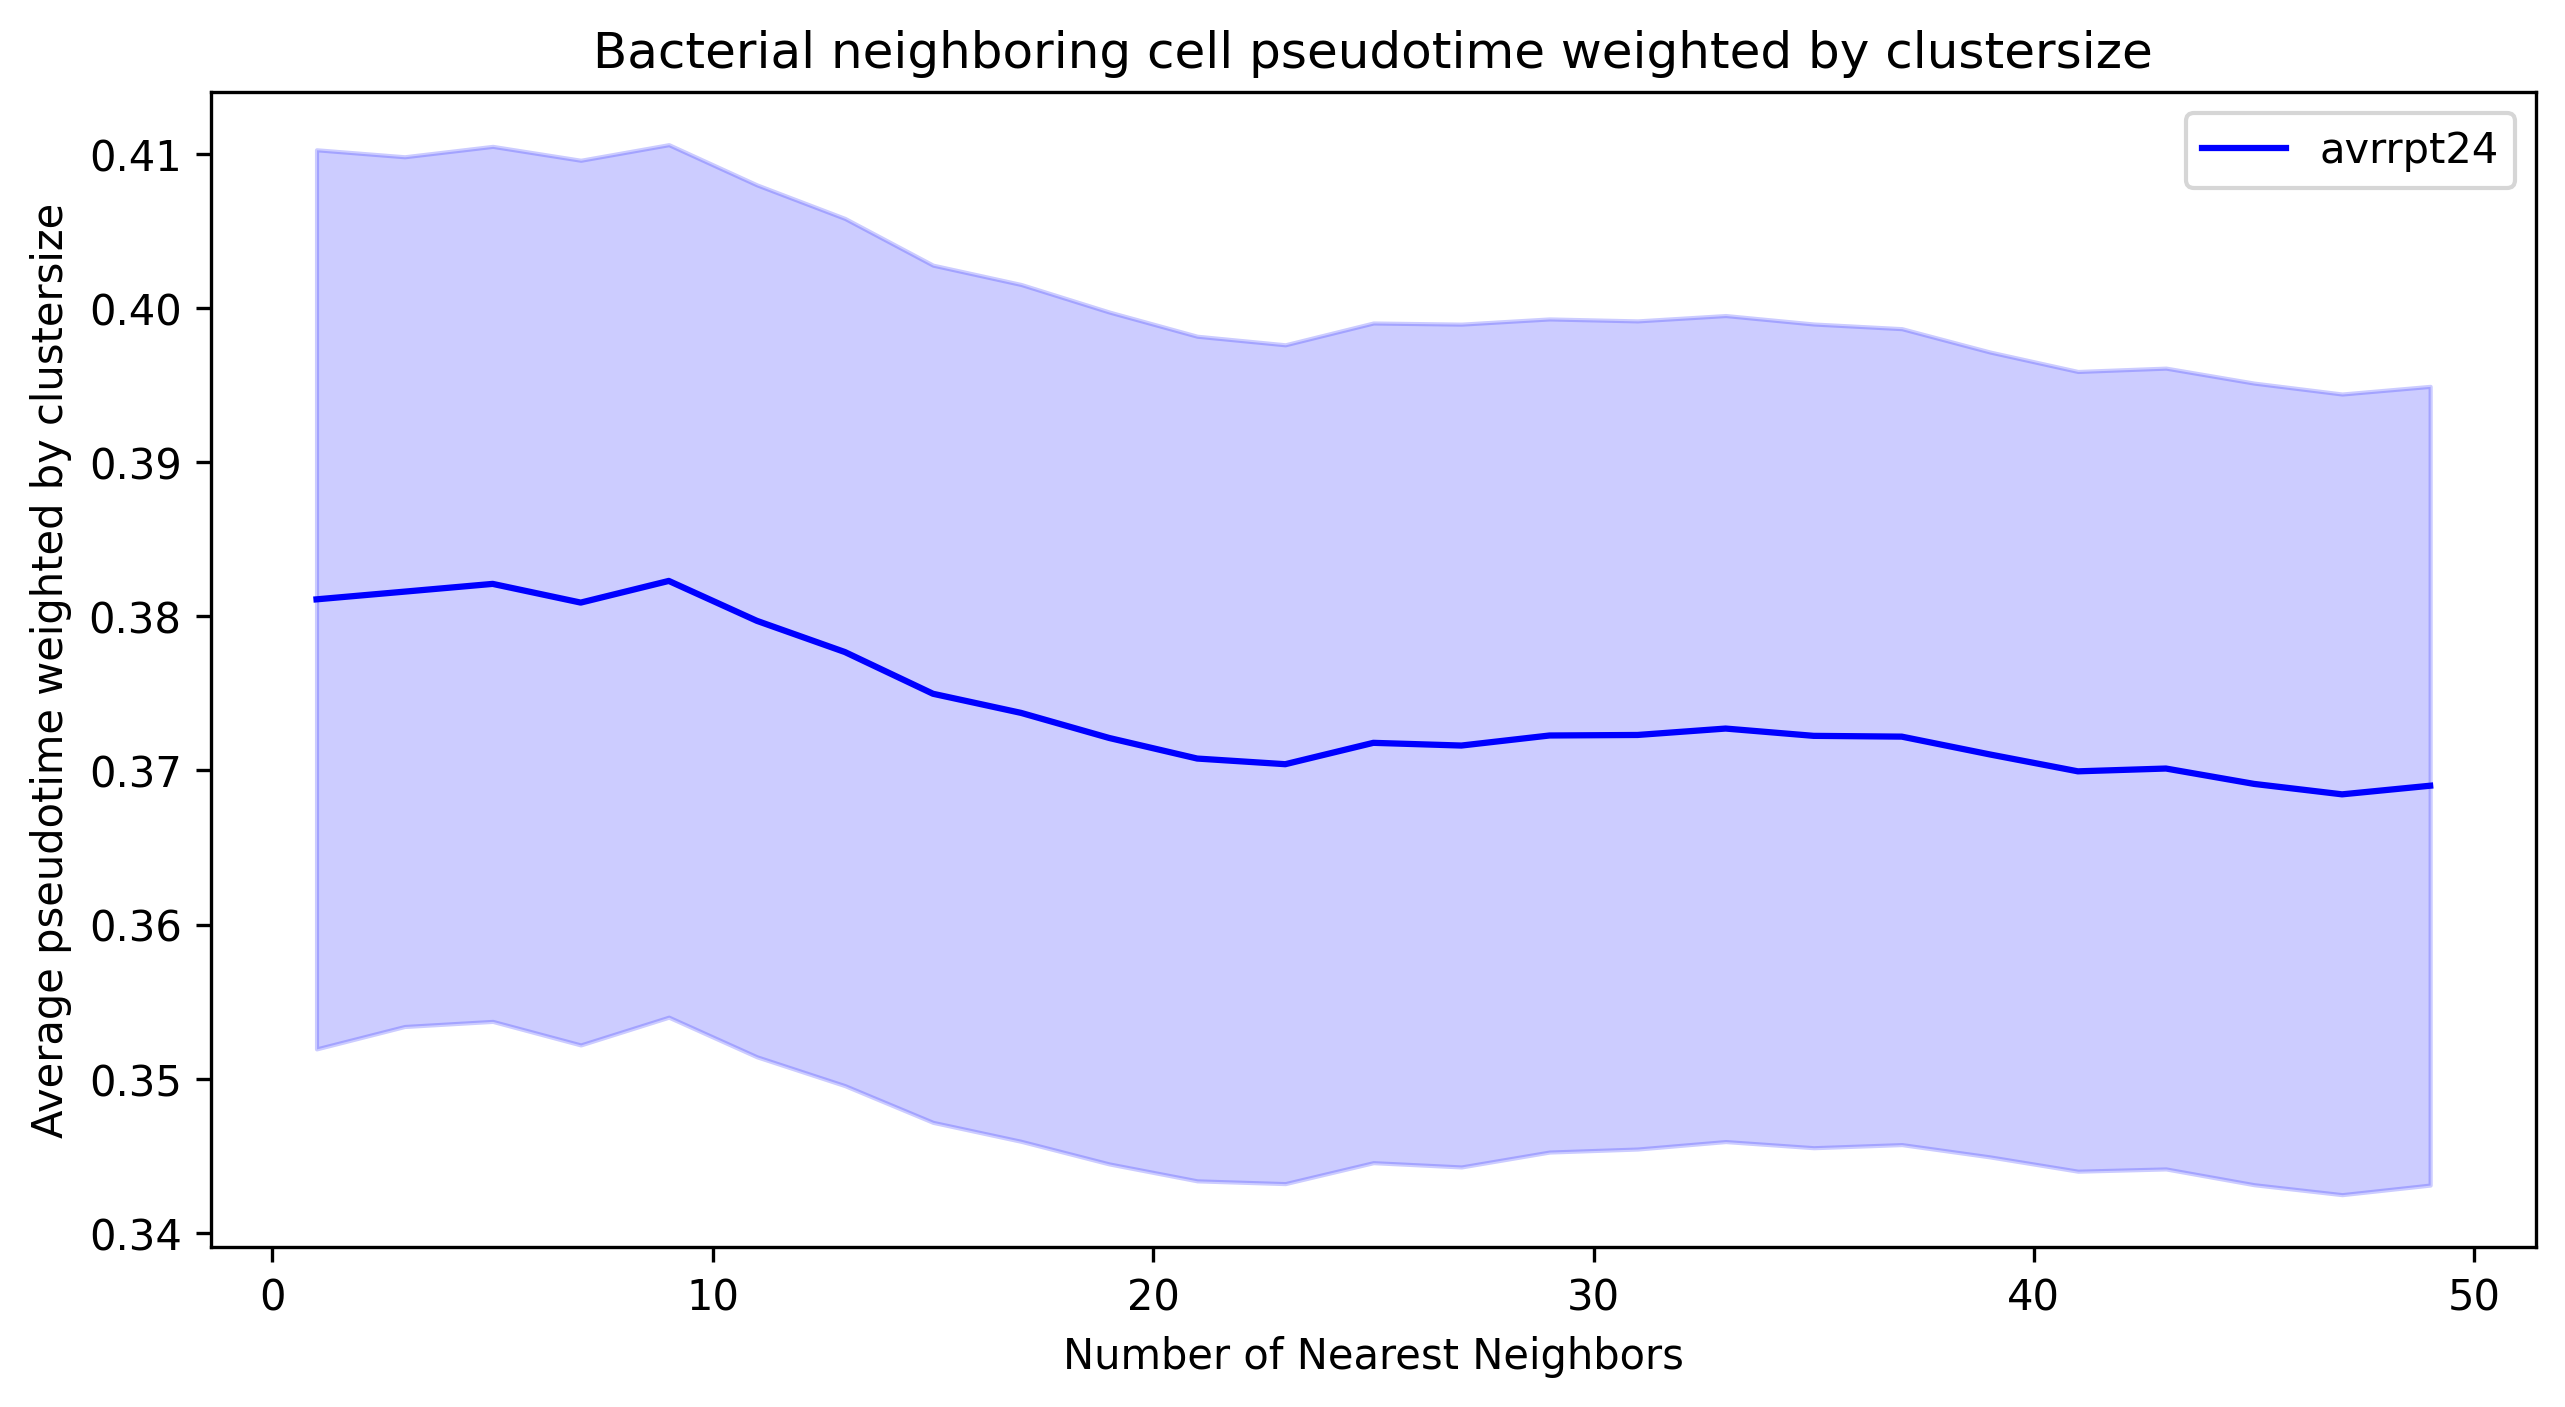

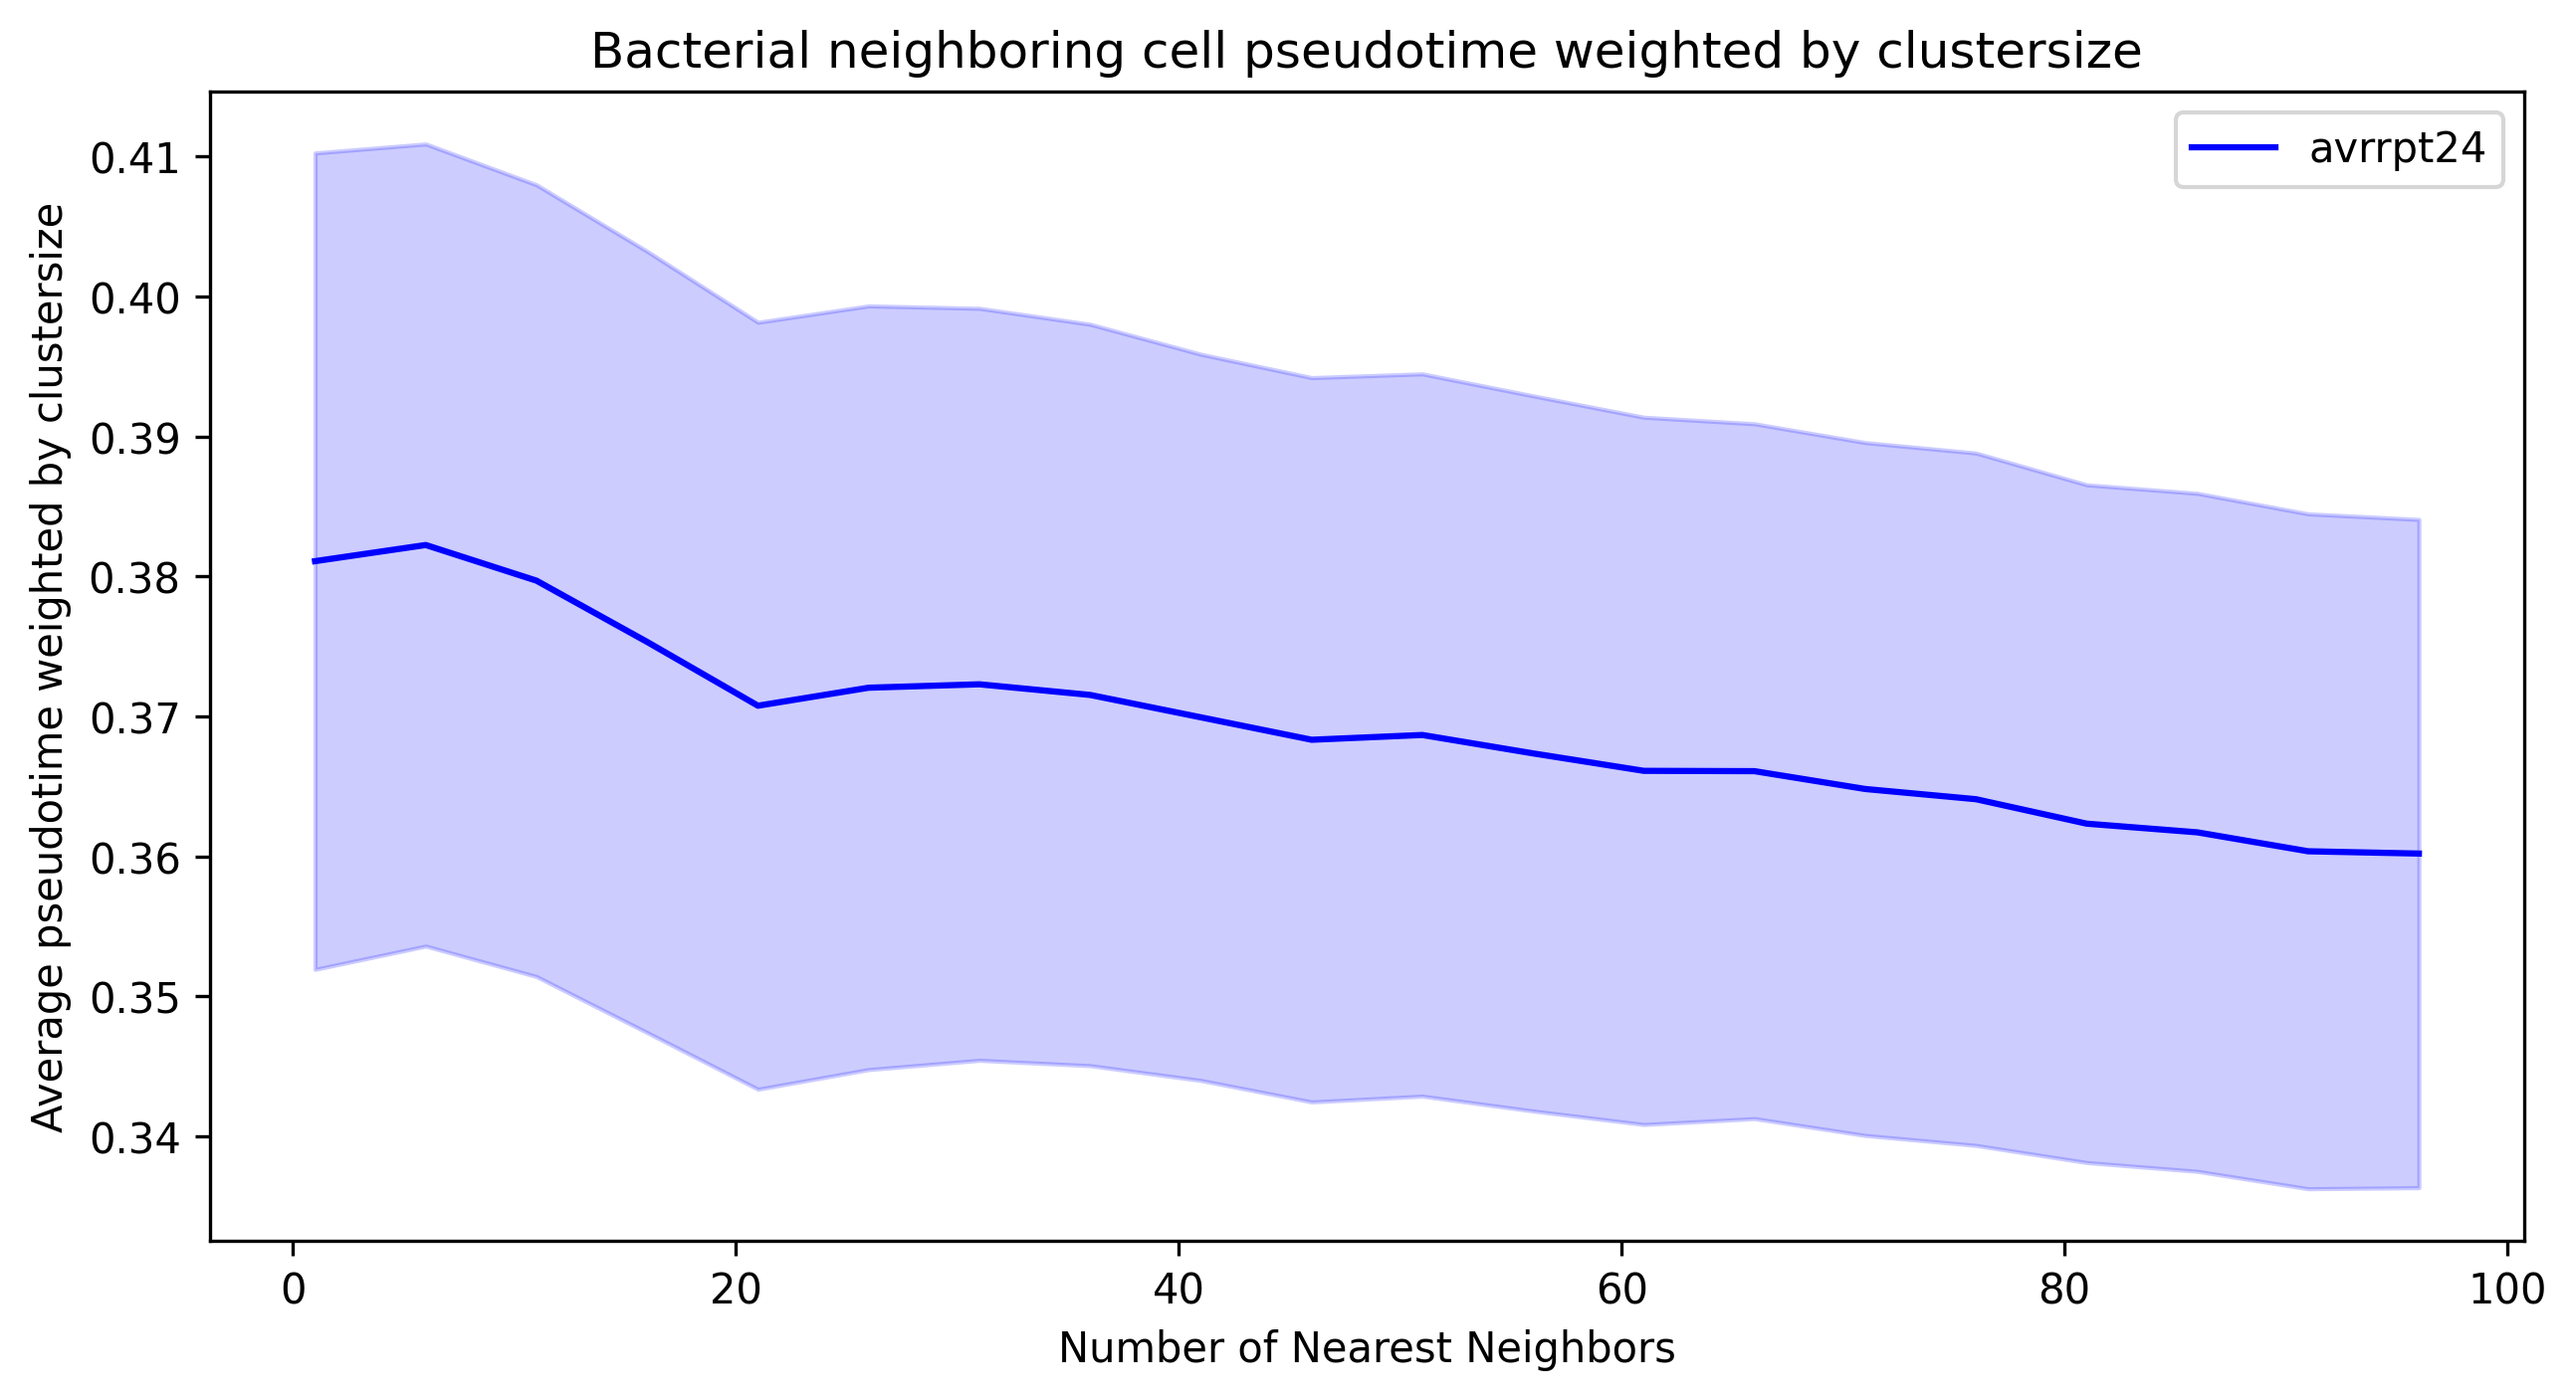

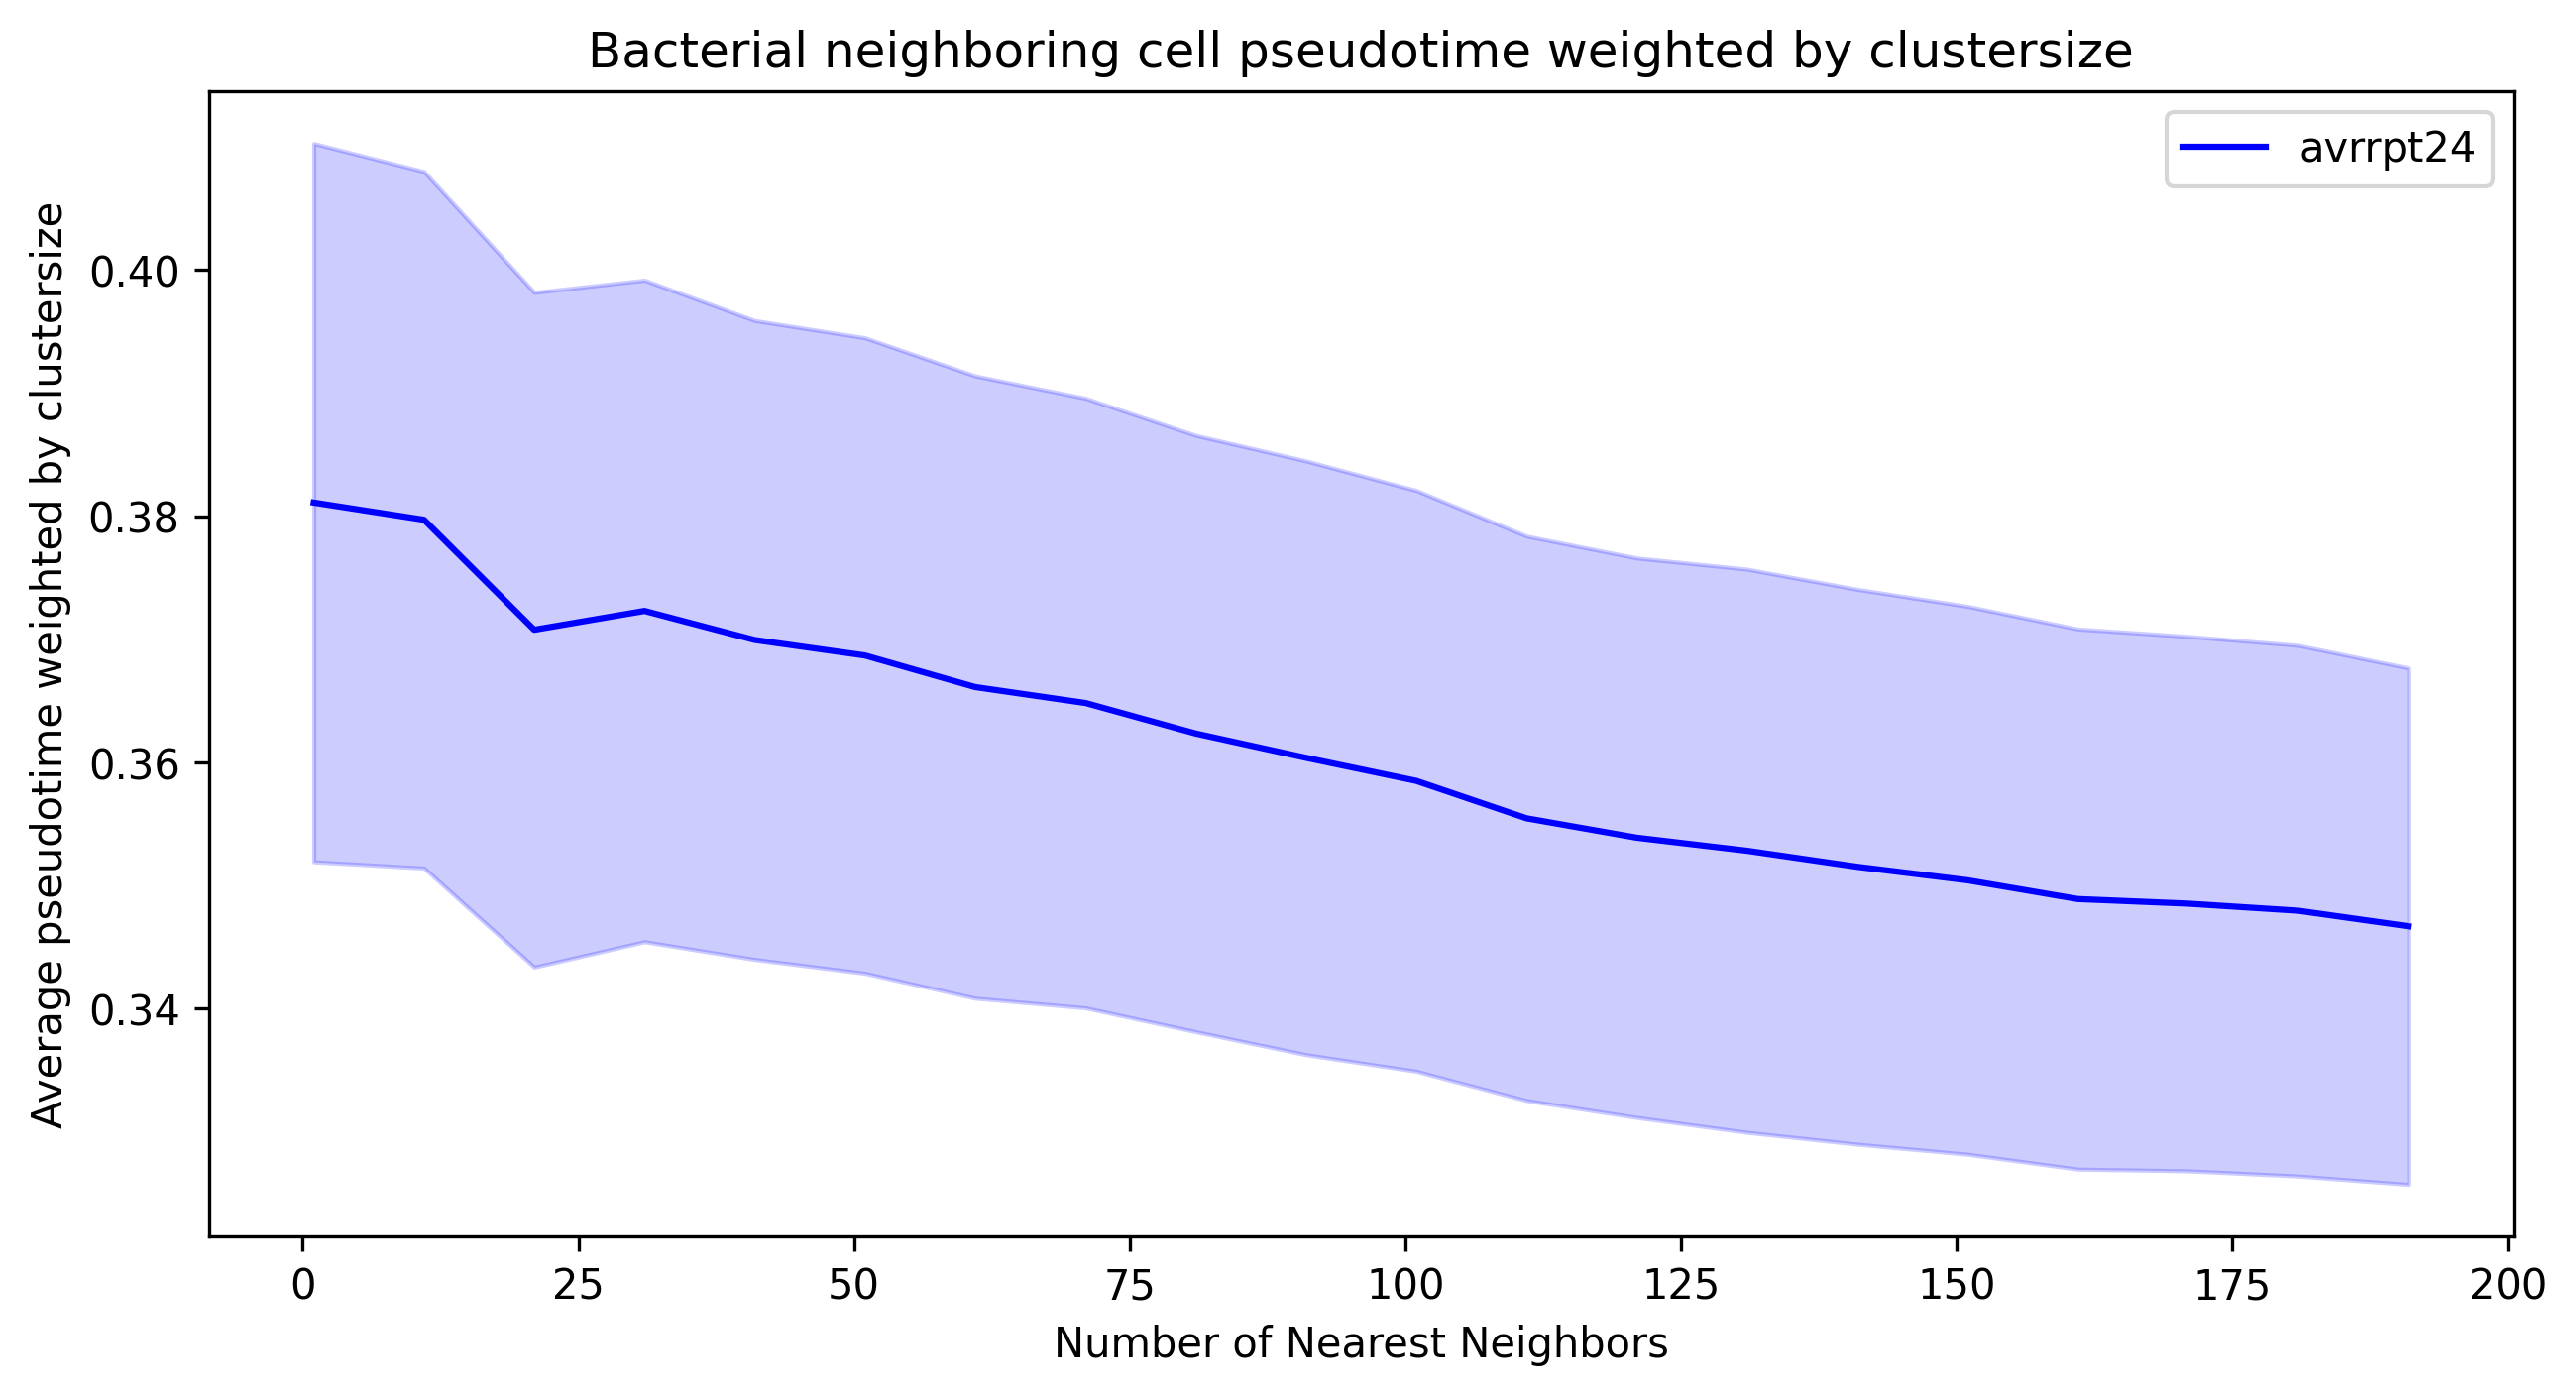

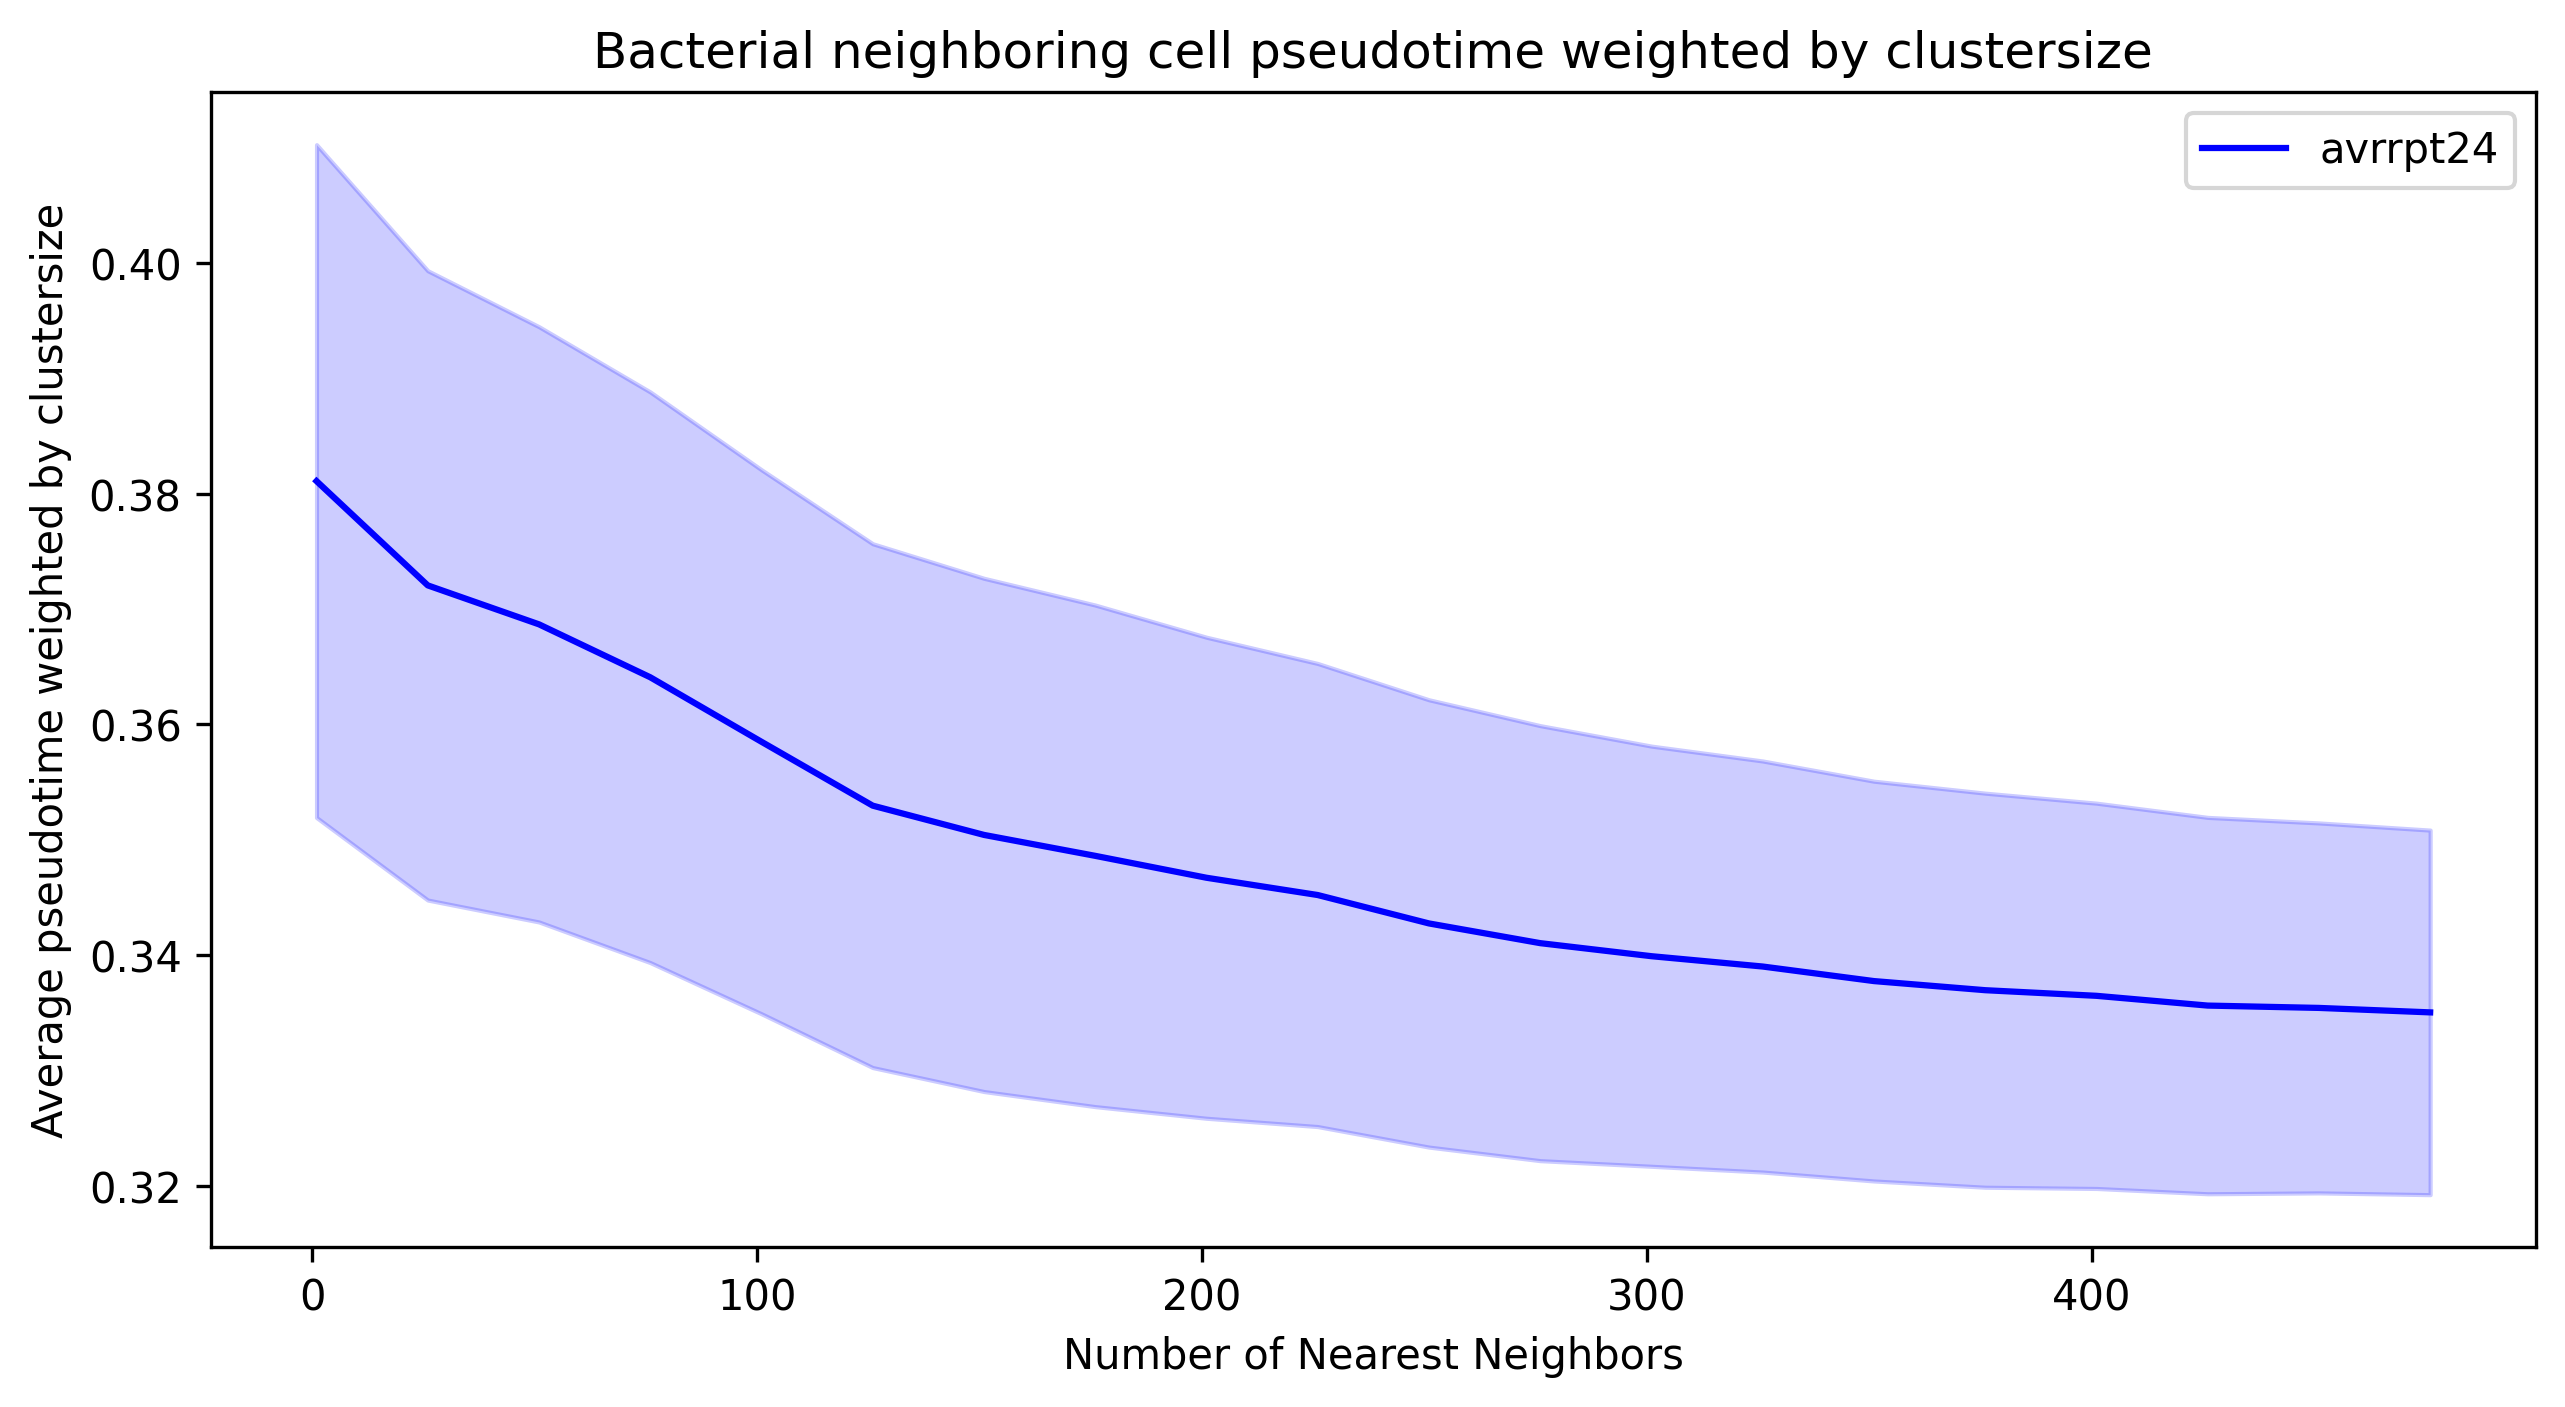

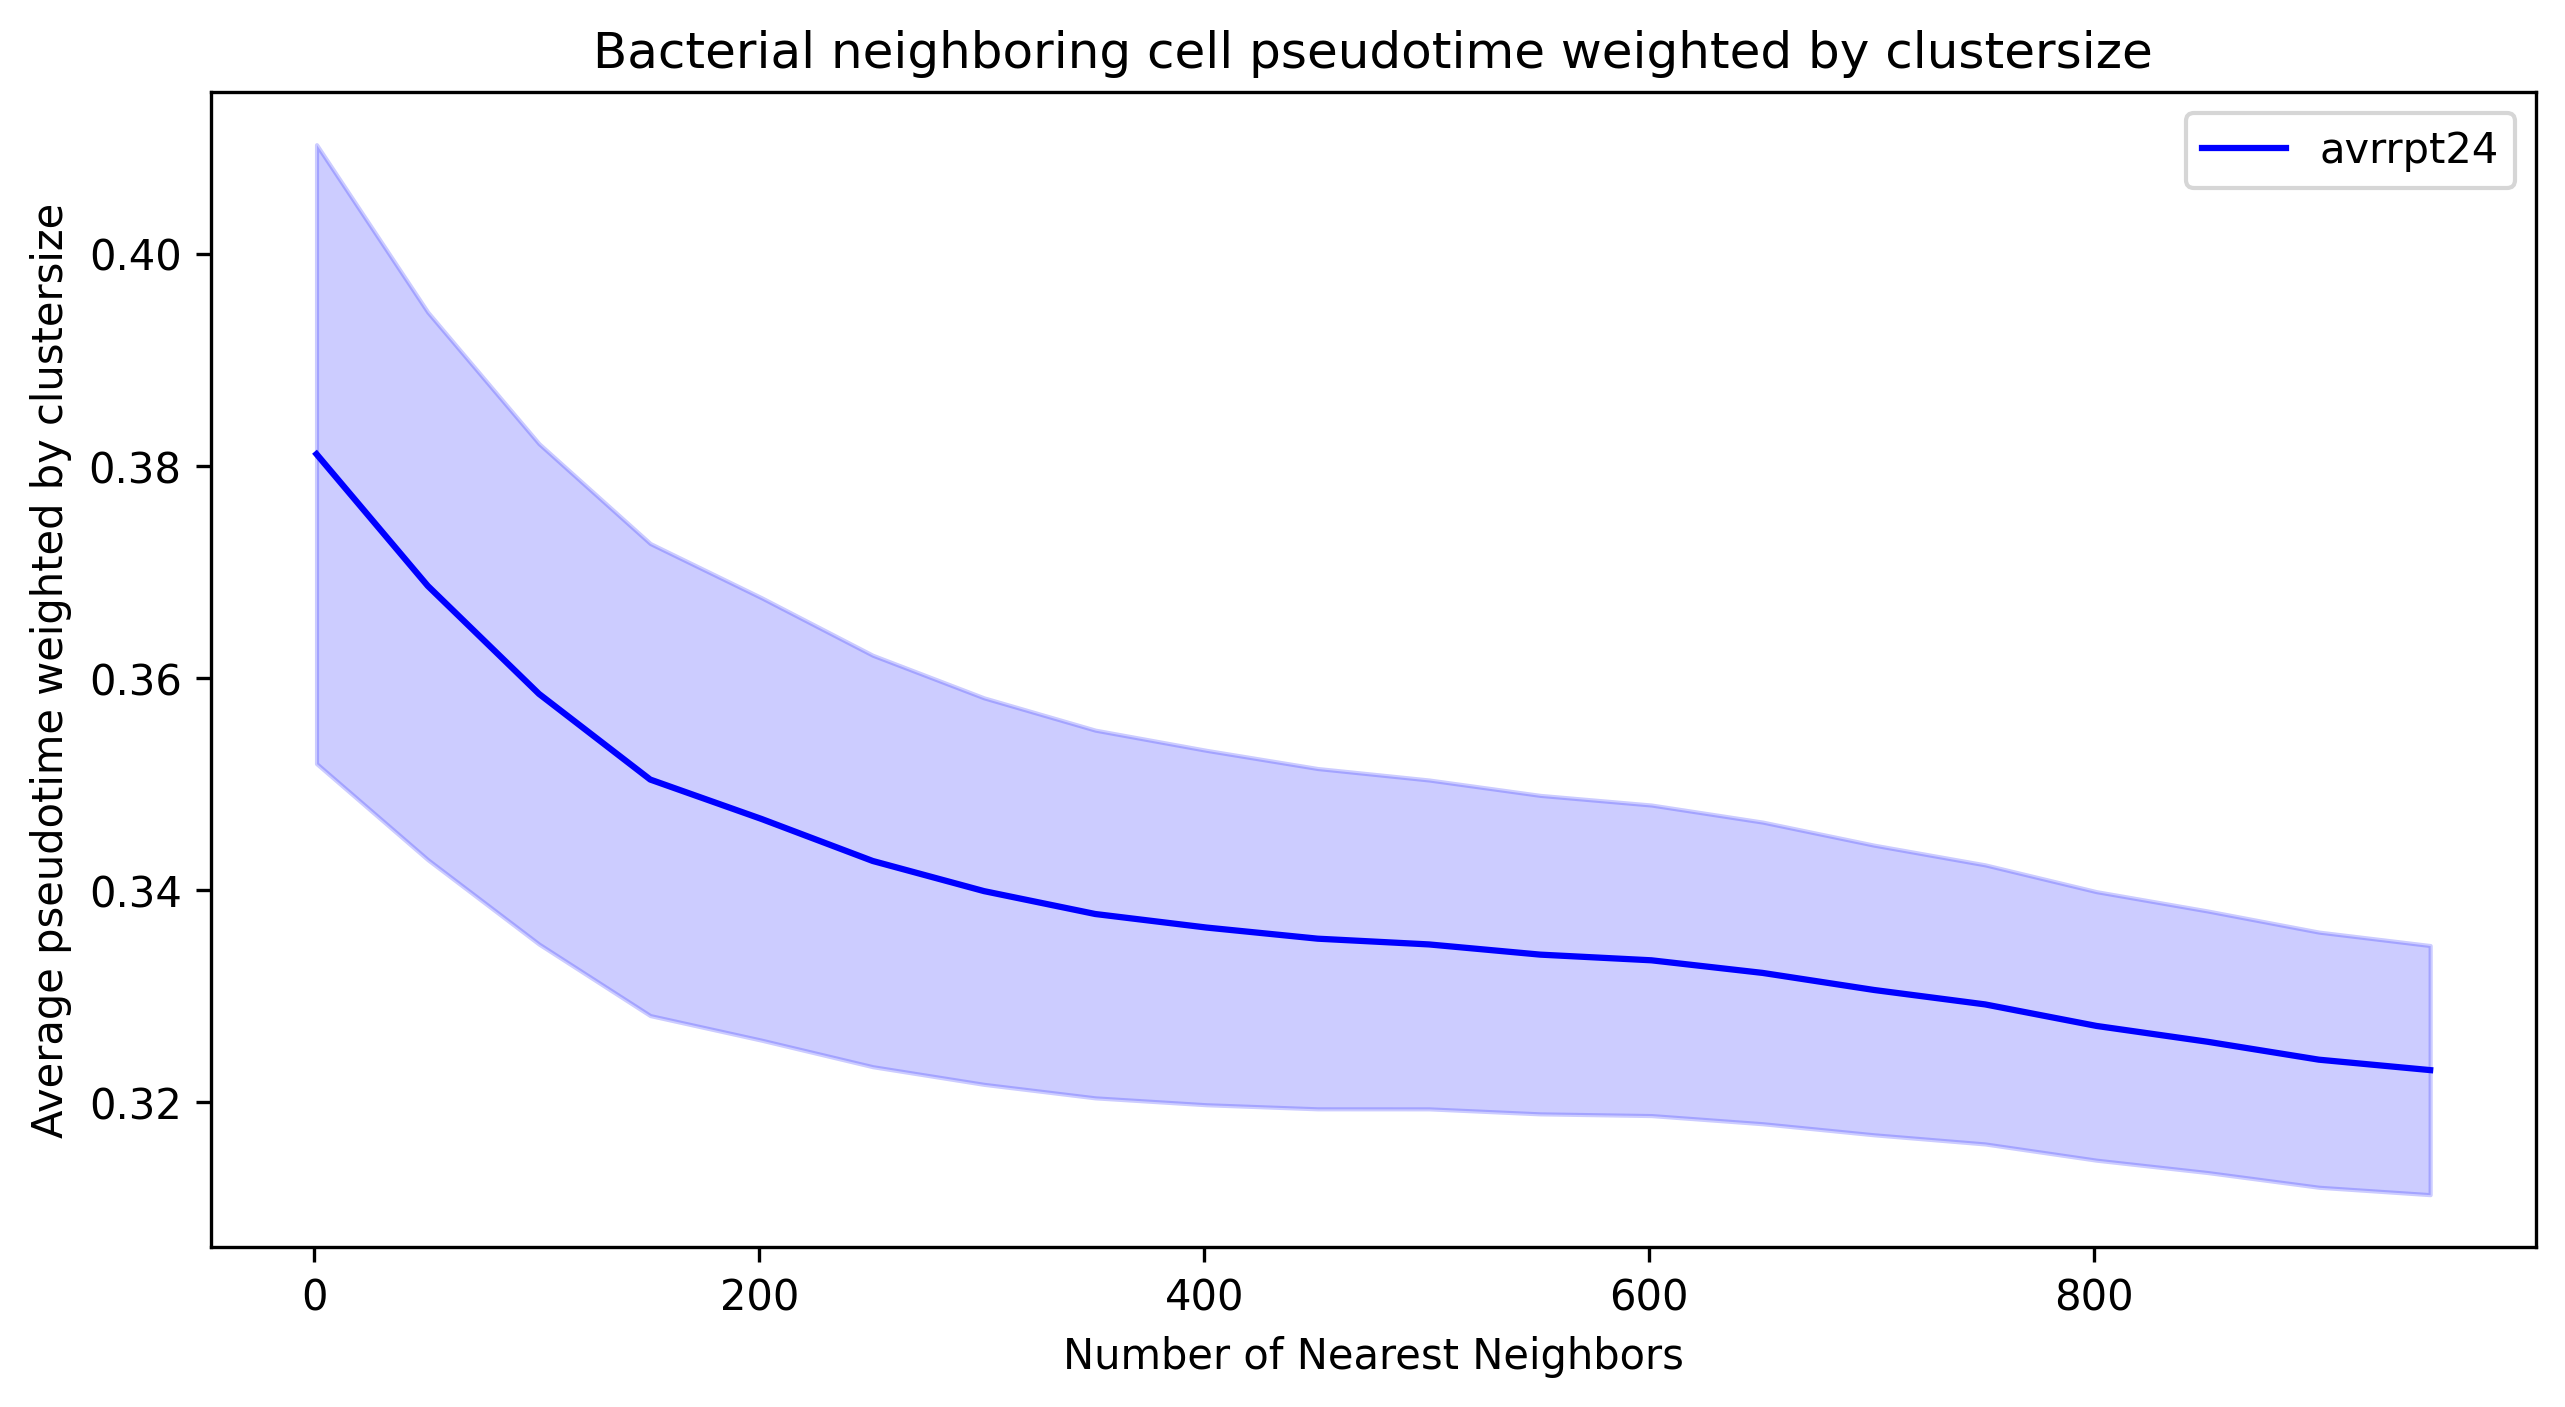

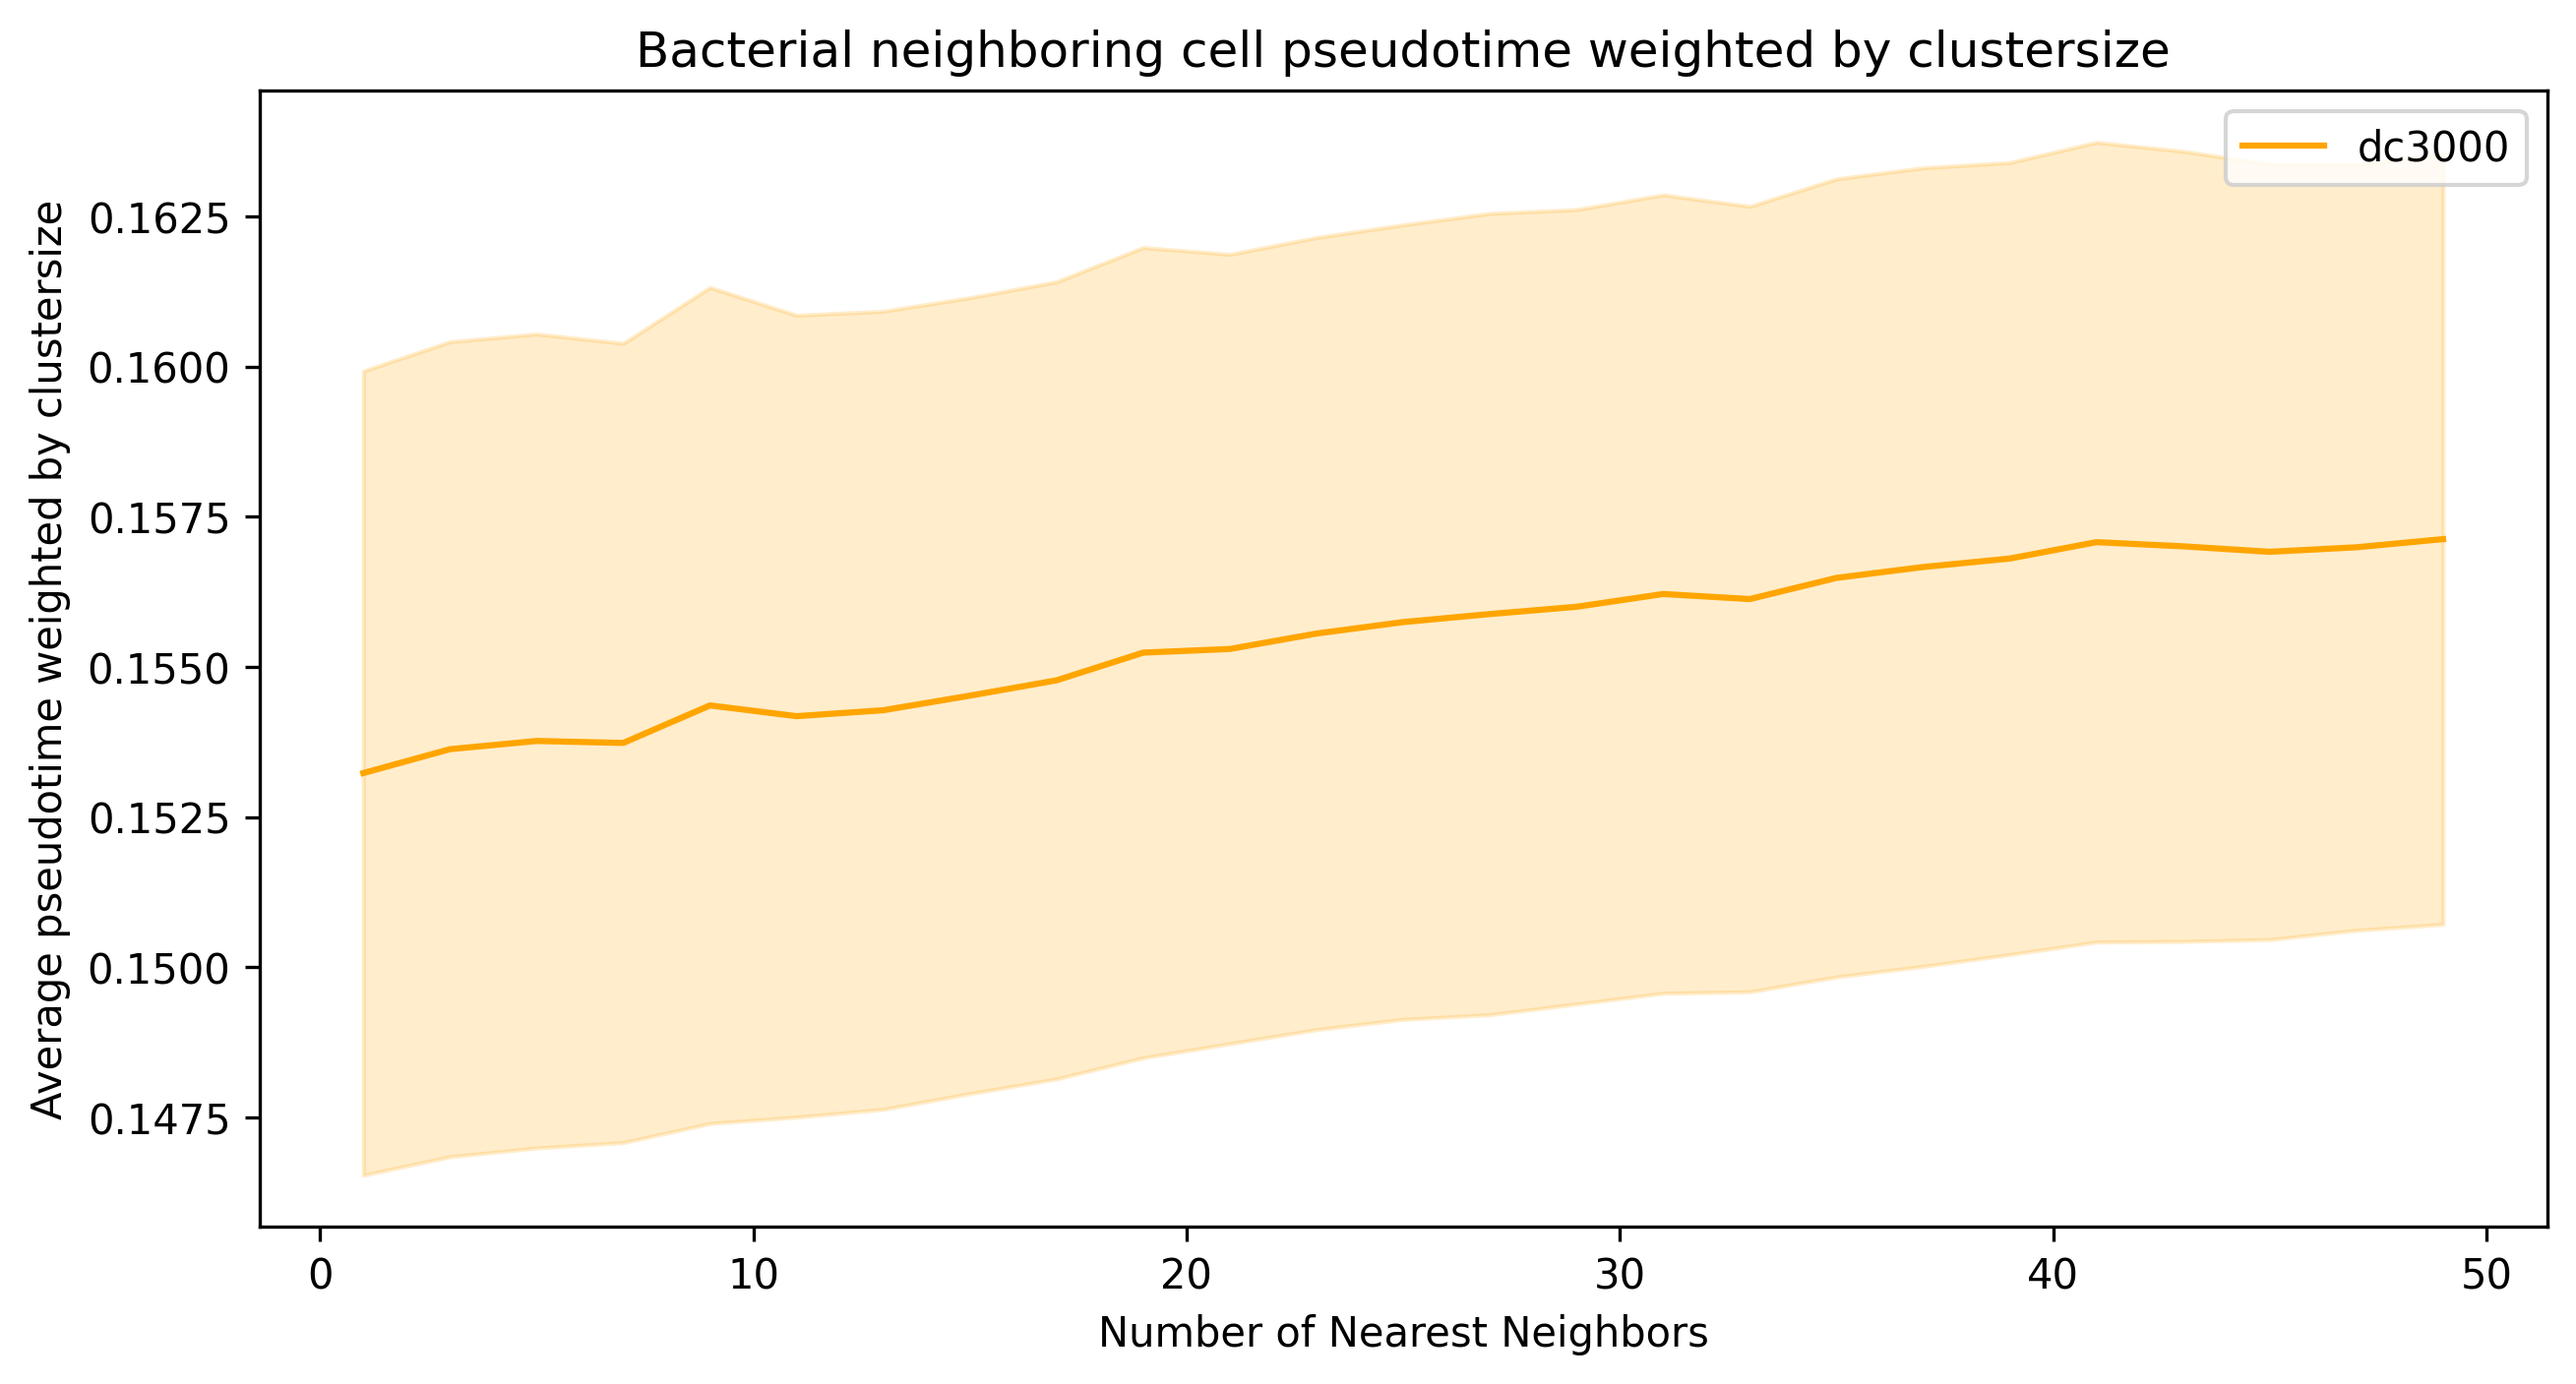

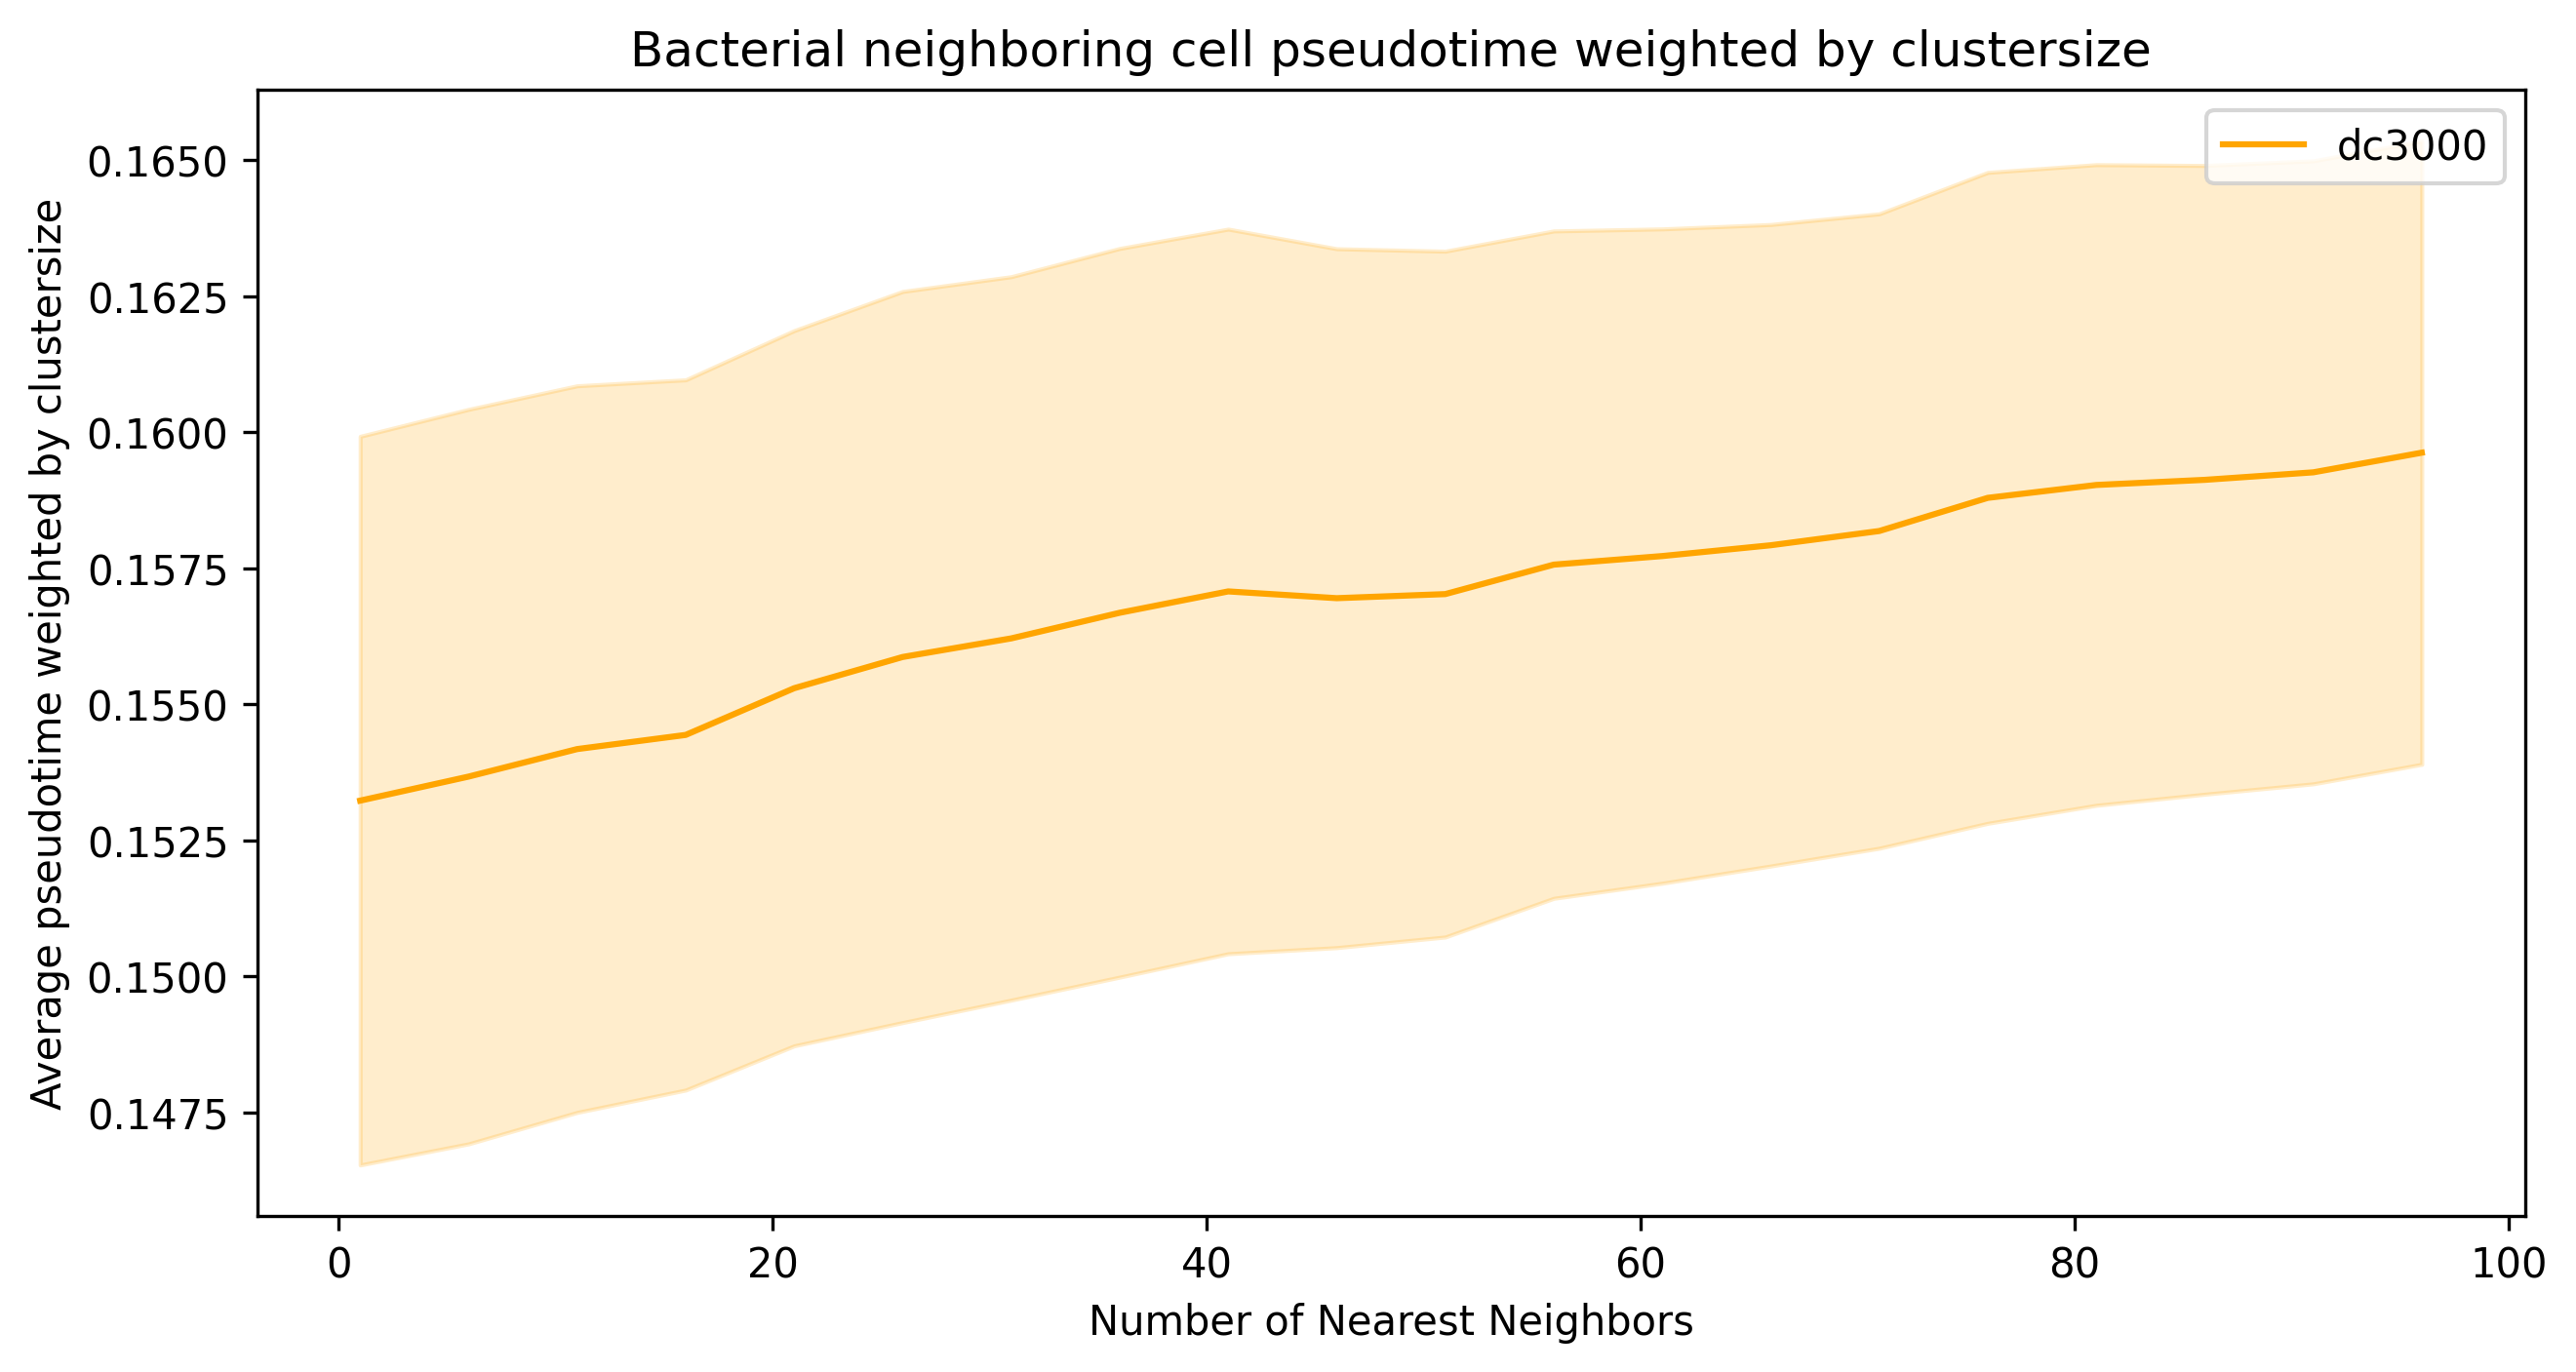

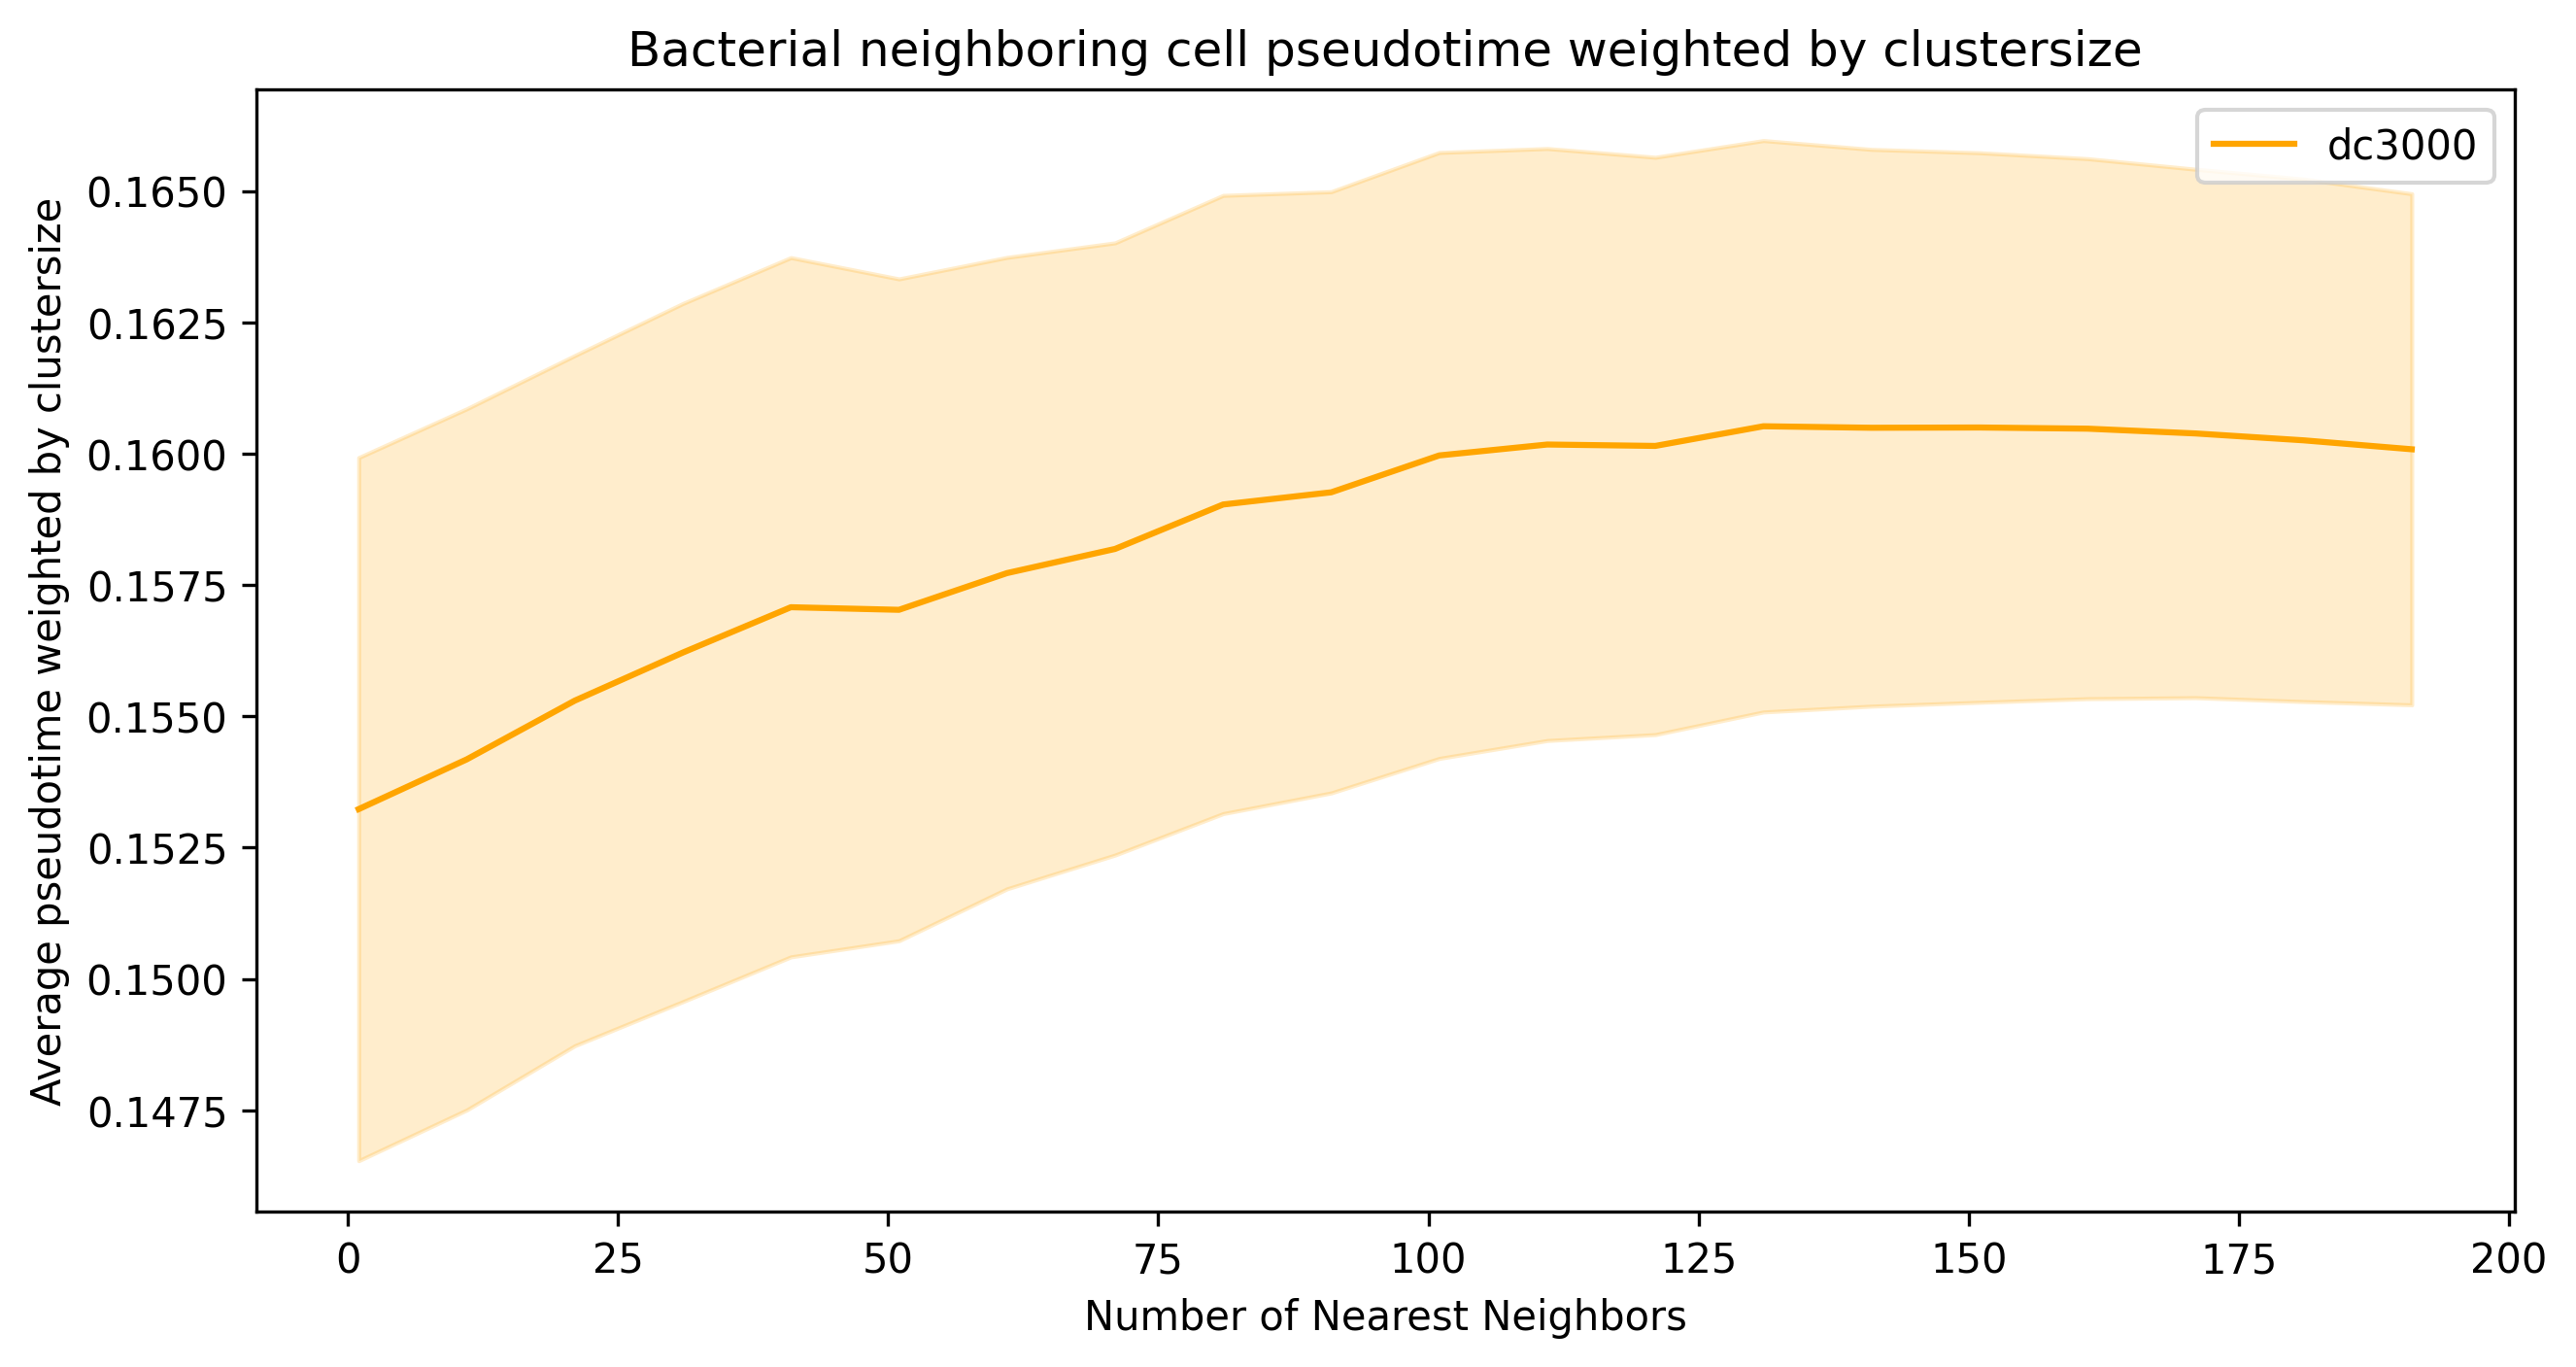

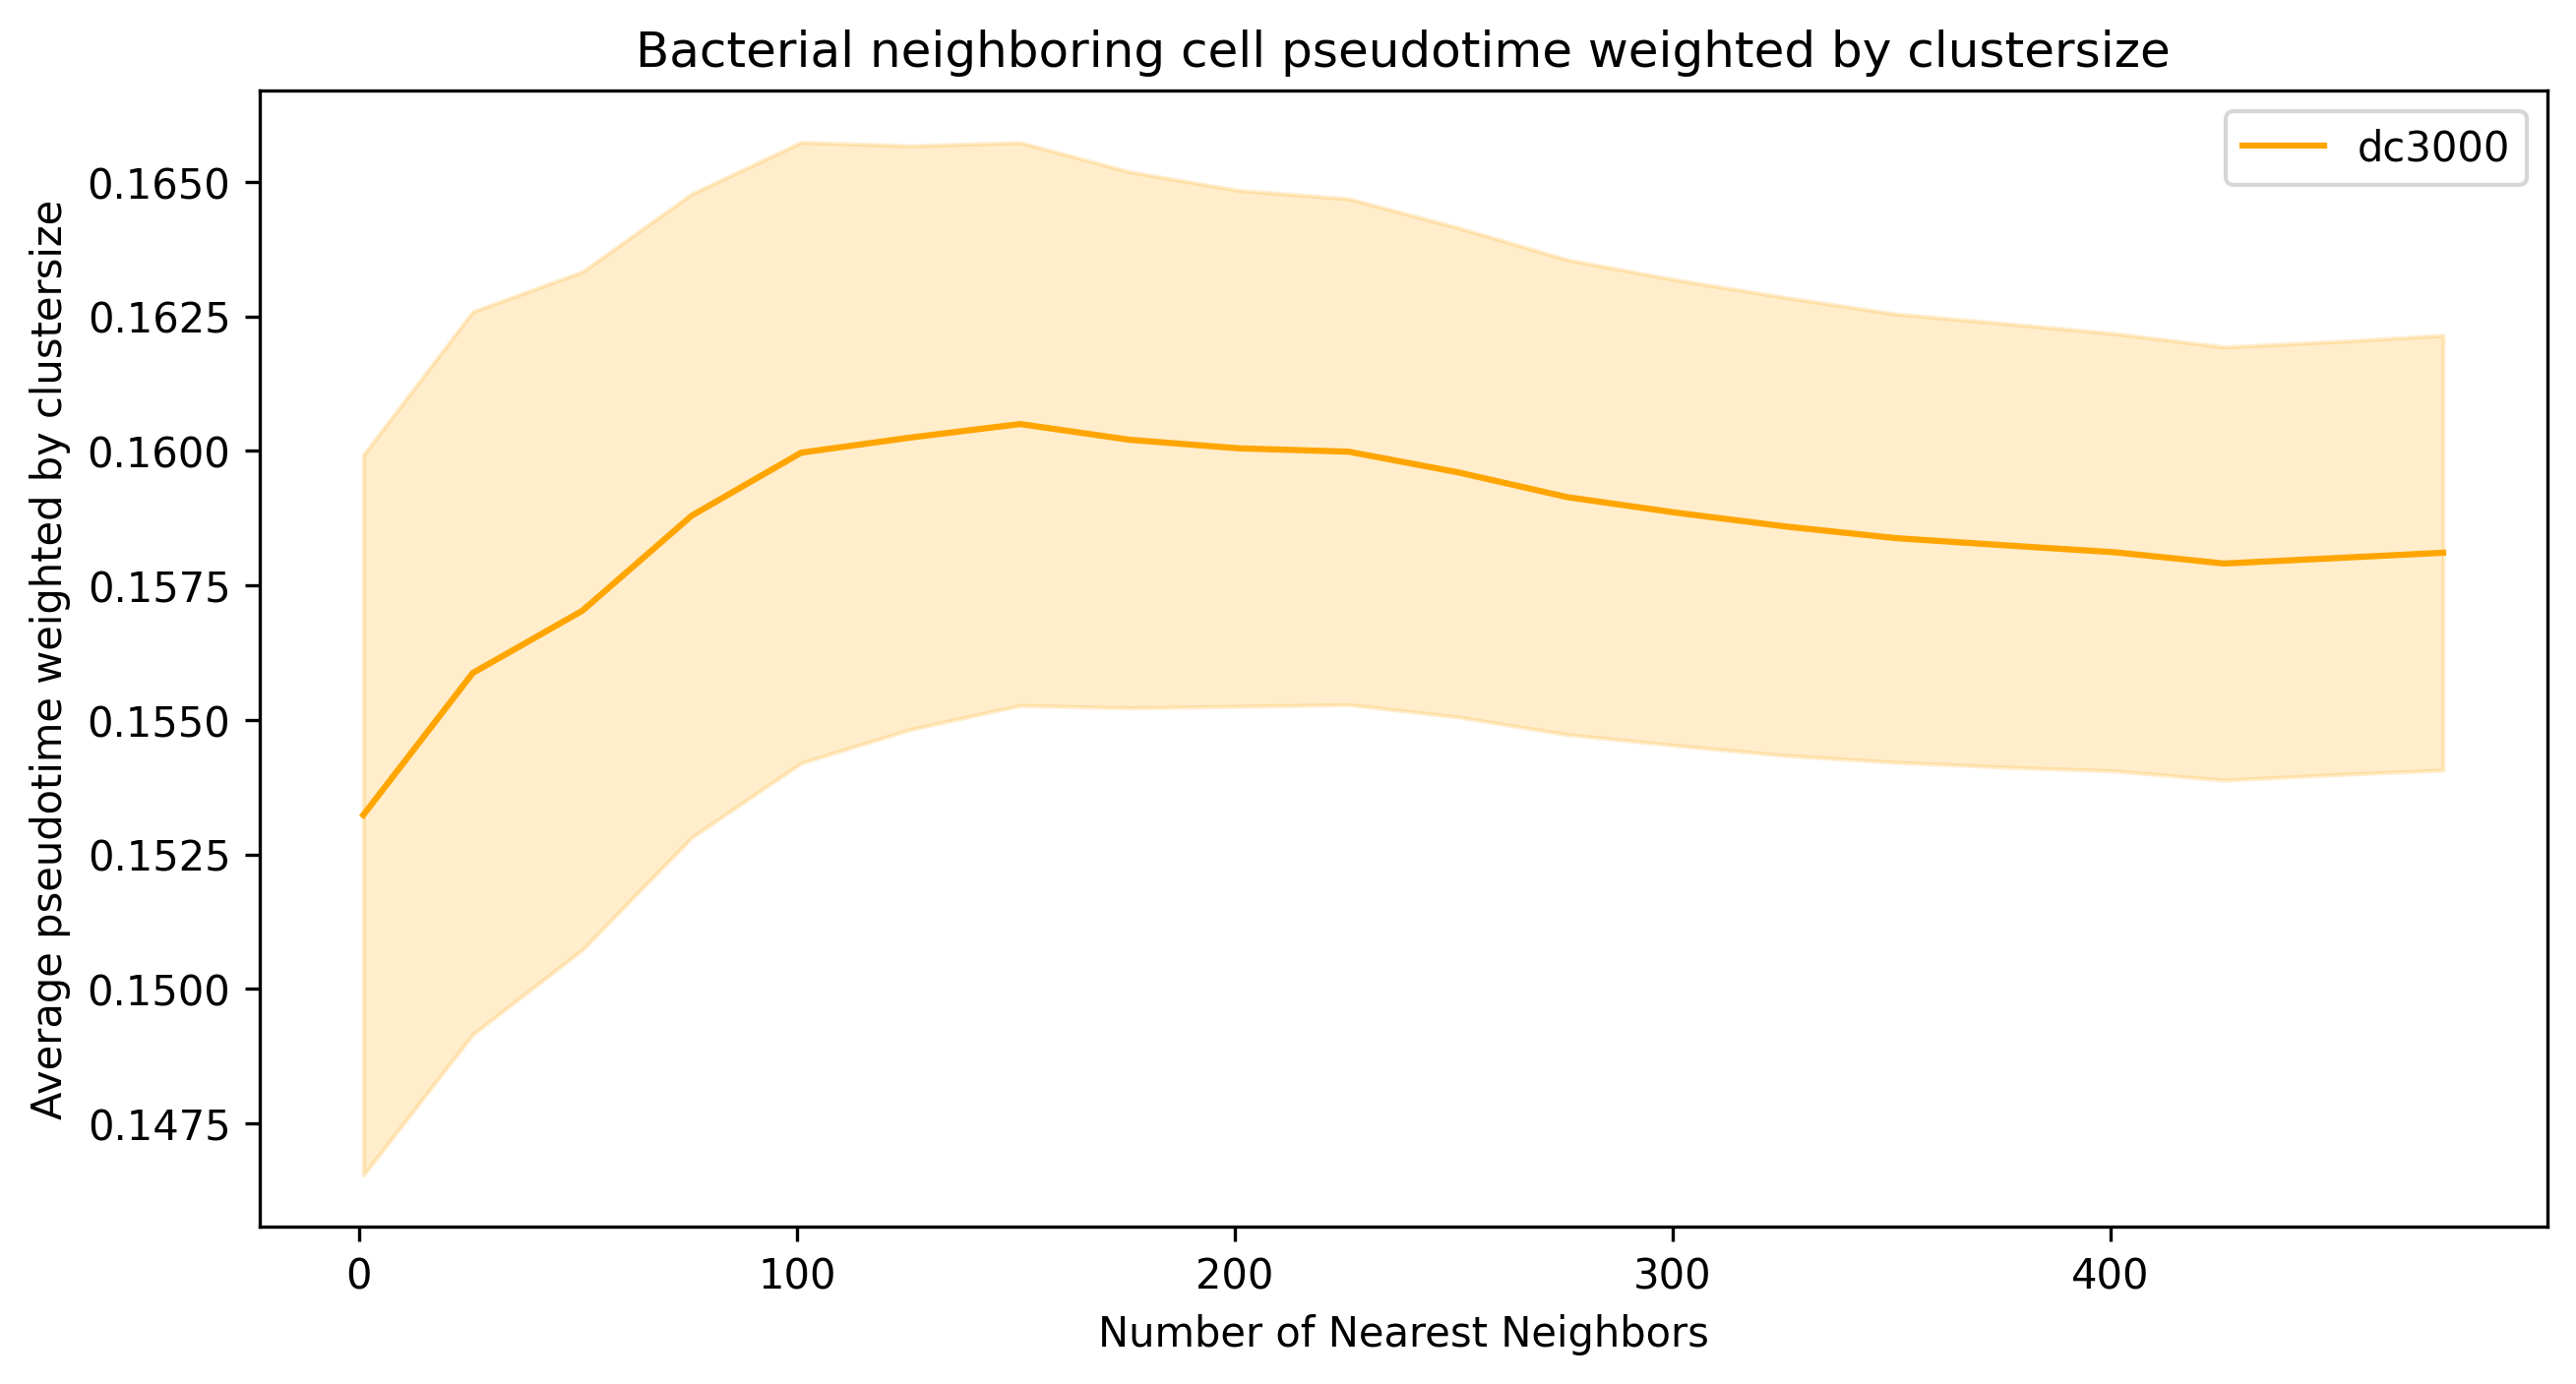

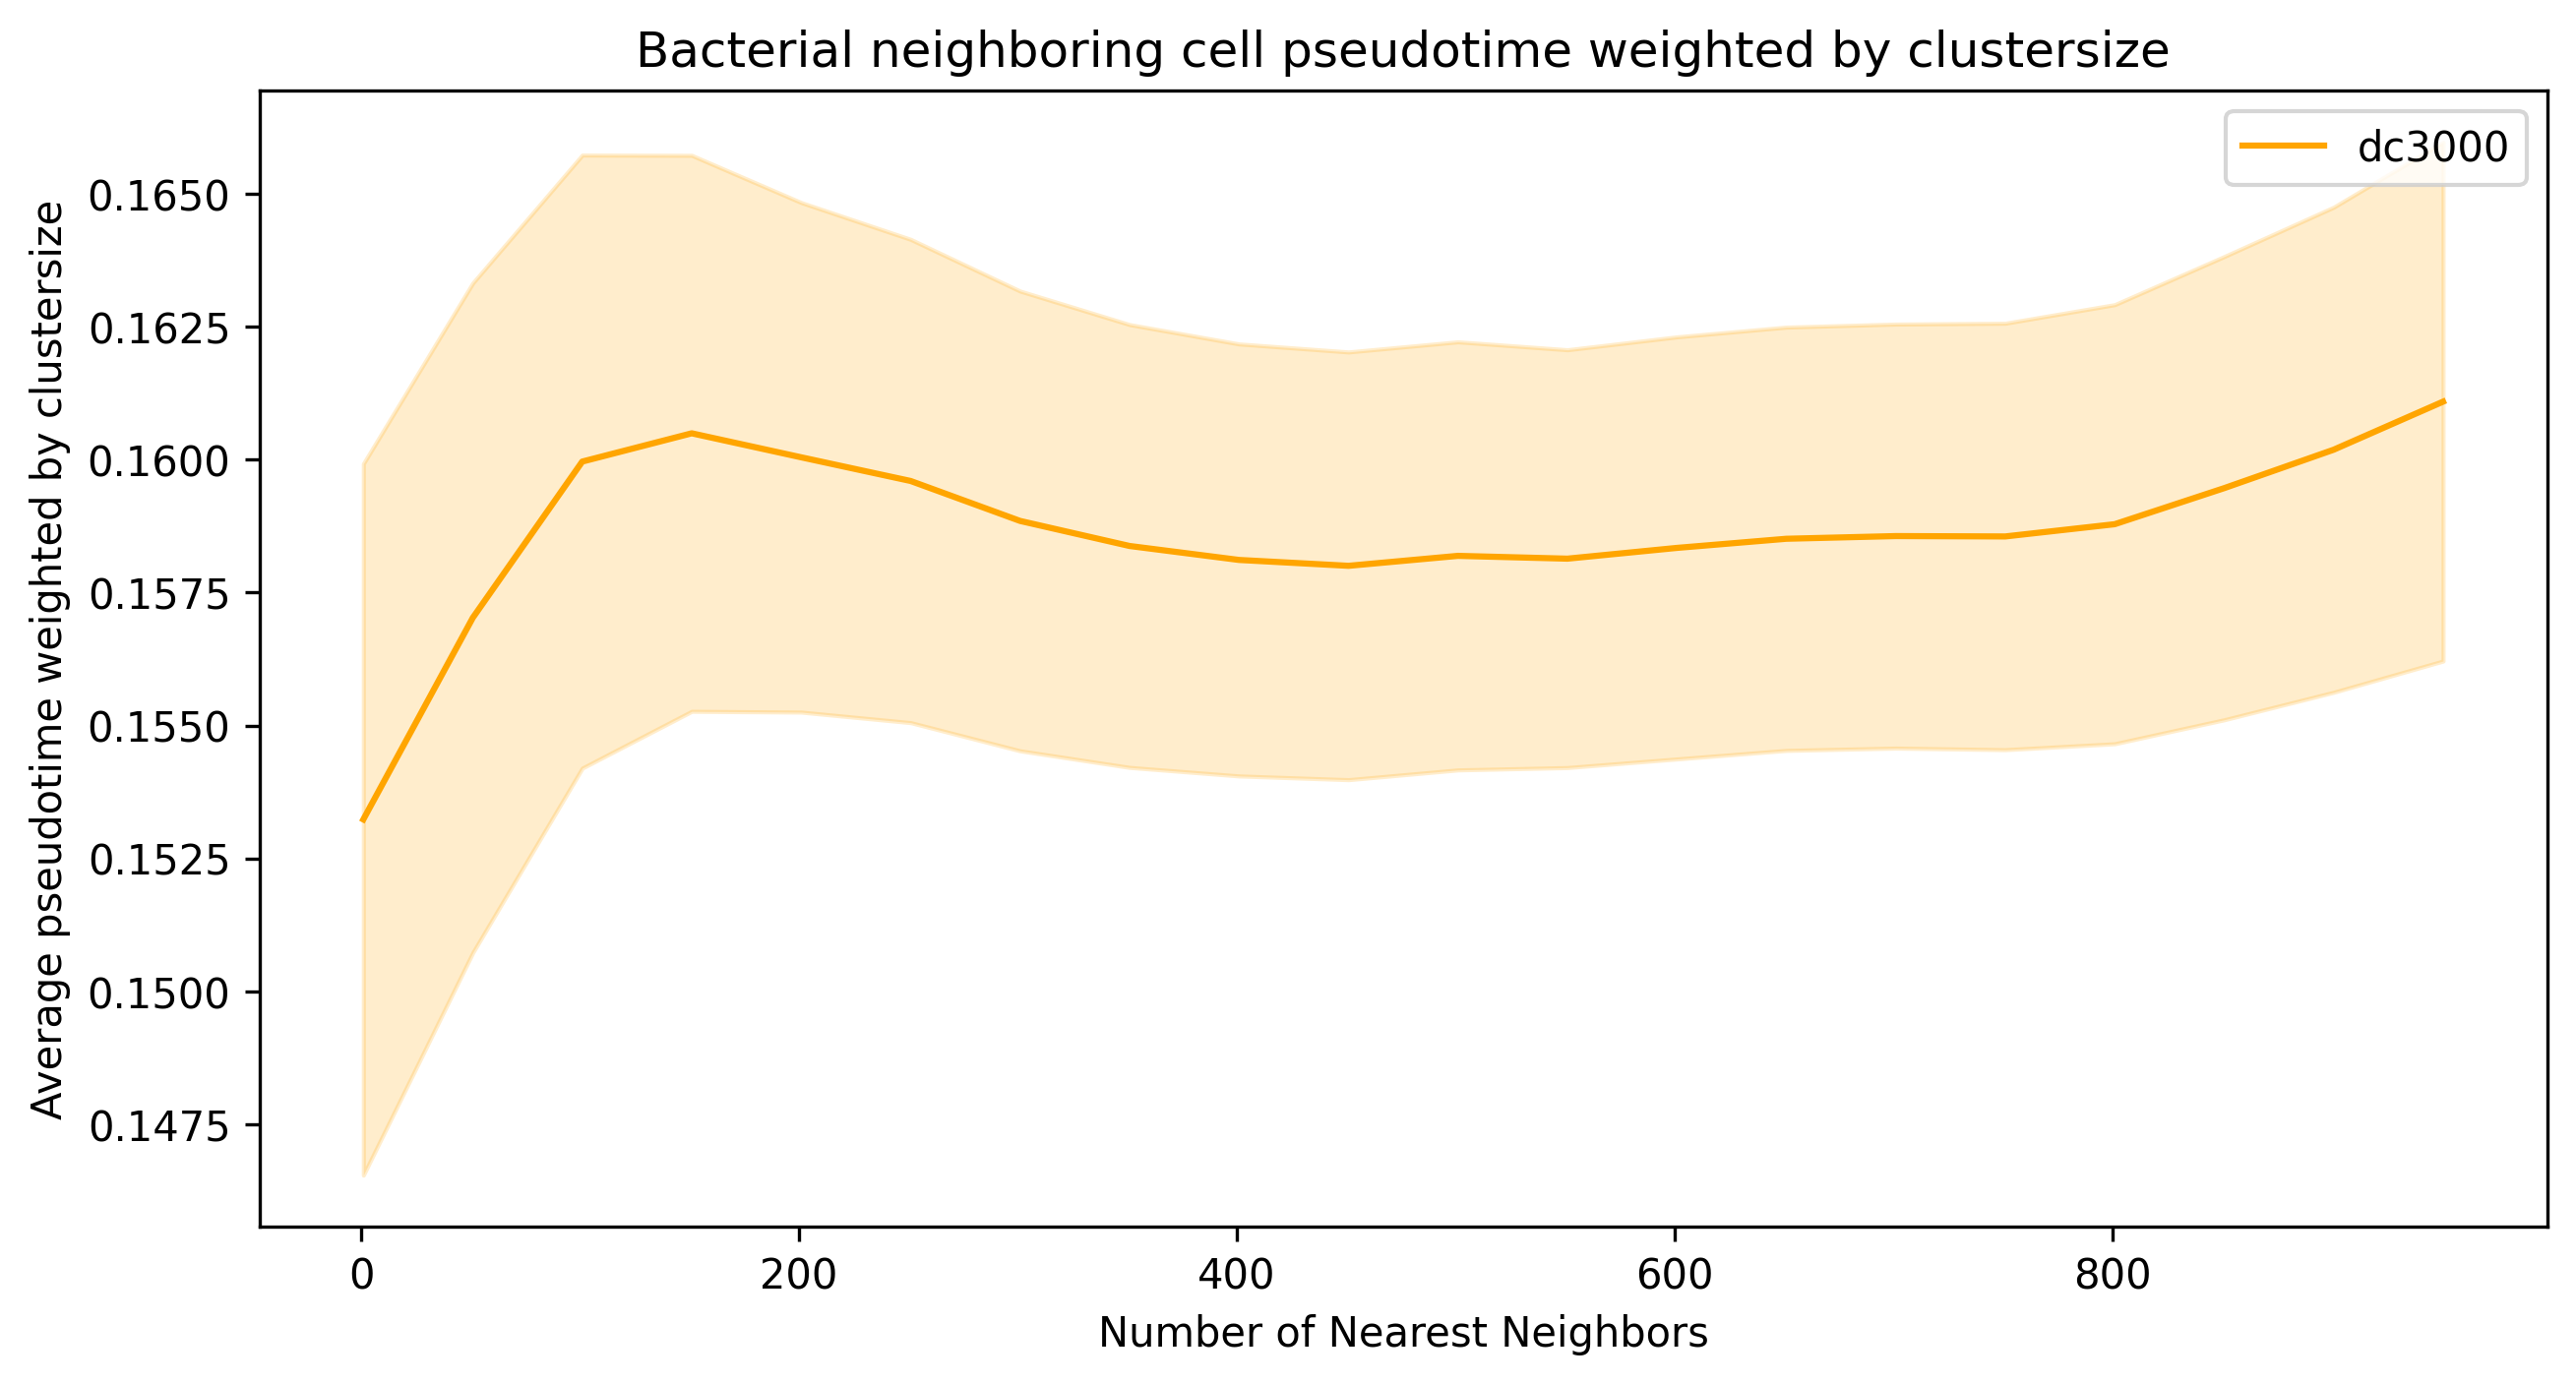

In [26]:
def weighted_variance(values, weights):
    mean = np.average(values, weights=weights)
    variance = np.average((values - mean)**2, weights=weights)
    return variance

colors = ['blue', 'orange']
sample_names = ['Avrrpt2 24h', 'DC3000 24h']

nums = [50, 100, 200, 500, 1000]
        
for k in range(len(samples)):
    for num in range(len(nums)):
        arrange = np.arange(1, nums[num], nums[num]//20)
        plt.figure(figsize=(10, 5), dpi=300)
        avg = np.average(all_pseudo[k][num], axis=1, weights=all_cluster[k][num])
        plt.plot(arrange, avg, color = colors[k], label = samples[k])

        variances = np.apply_along_axis(weighted_variance, 1, all_pseudo[k][num], all_cluster[k][num])

        n_eff = len(all_cluster[k][num])  # effective number of samples
        sem = np.sqrt(variances / n_eff)

        plt.fill_between(arrange, avg - sem, avg + sem, color=colors[k], alpha=0.2)

        plt.xlabel('Number of Nearest Neighbors')
        plt.ylabel('Average pseudotime weighted by clustersize')
        plt.title('Bacterial neighboring cell pseudotime weighted by clustersize')
        plt.legend()
        plt.savefig(os.path.join(samples[k], f'pseudotime_weighted_by_clustersize_{nums[num]}.pdf'))
        plt.show()
        plt.close()


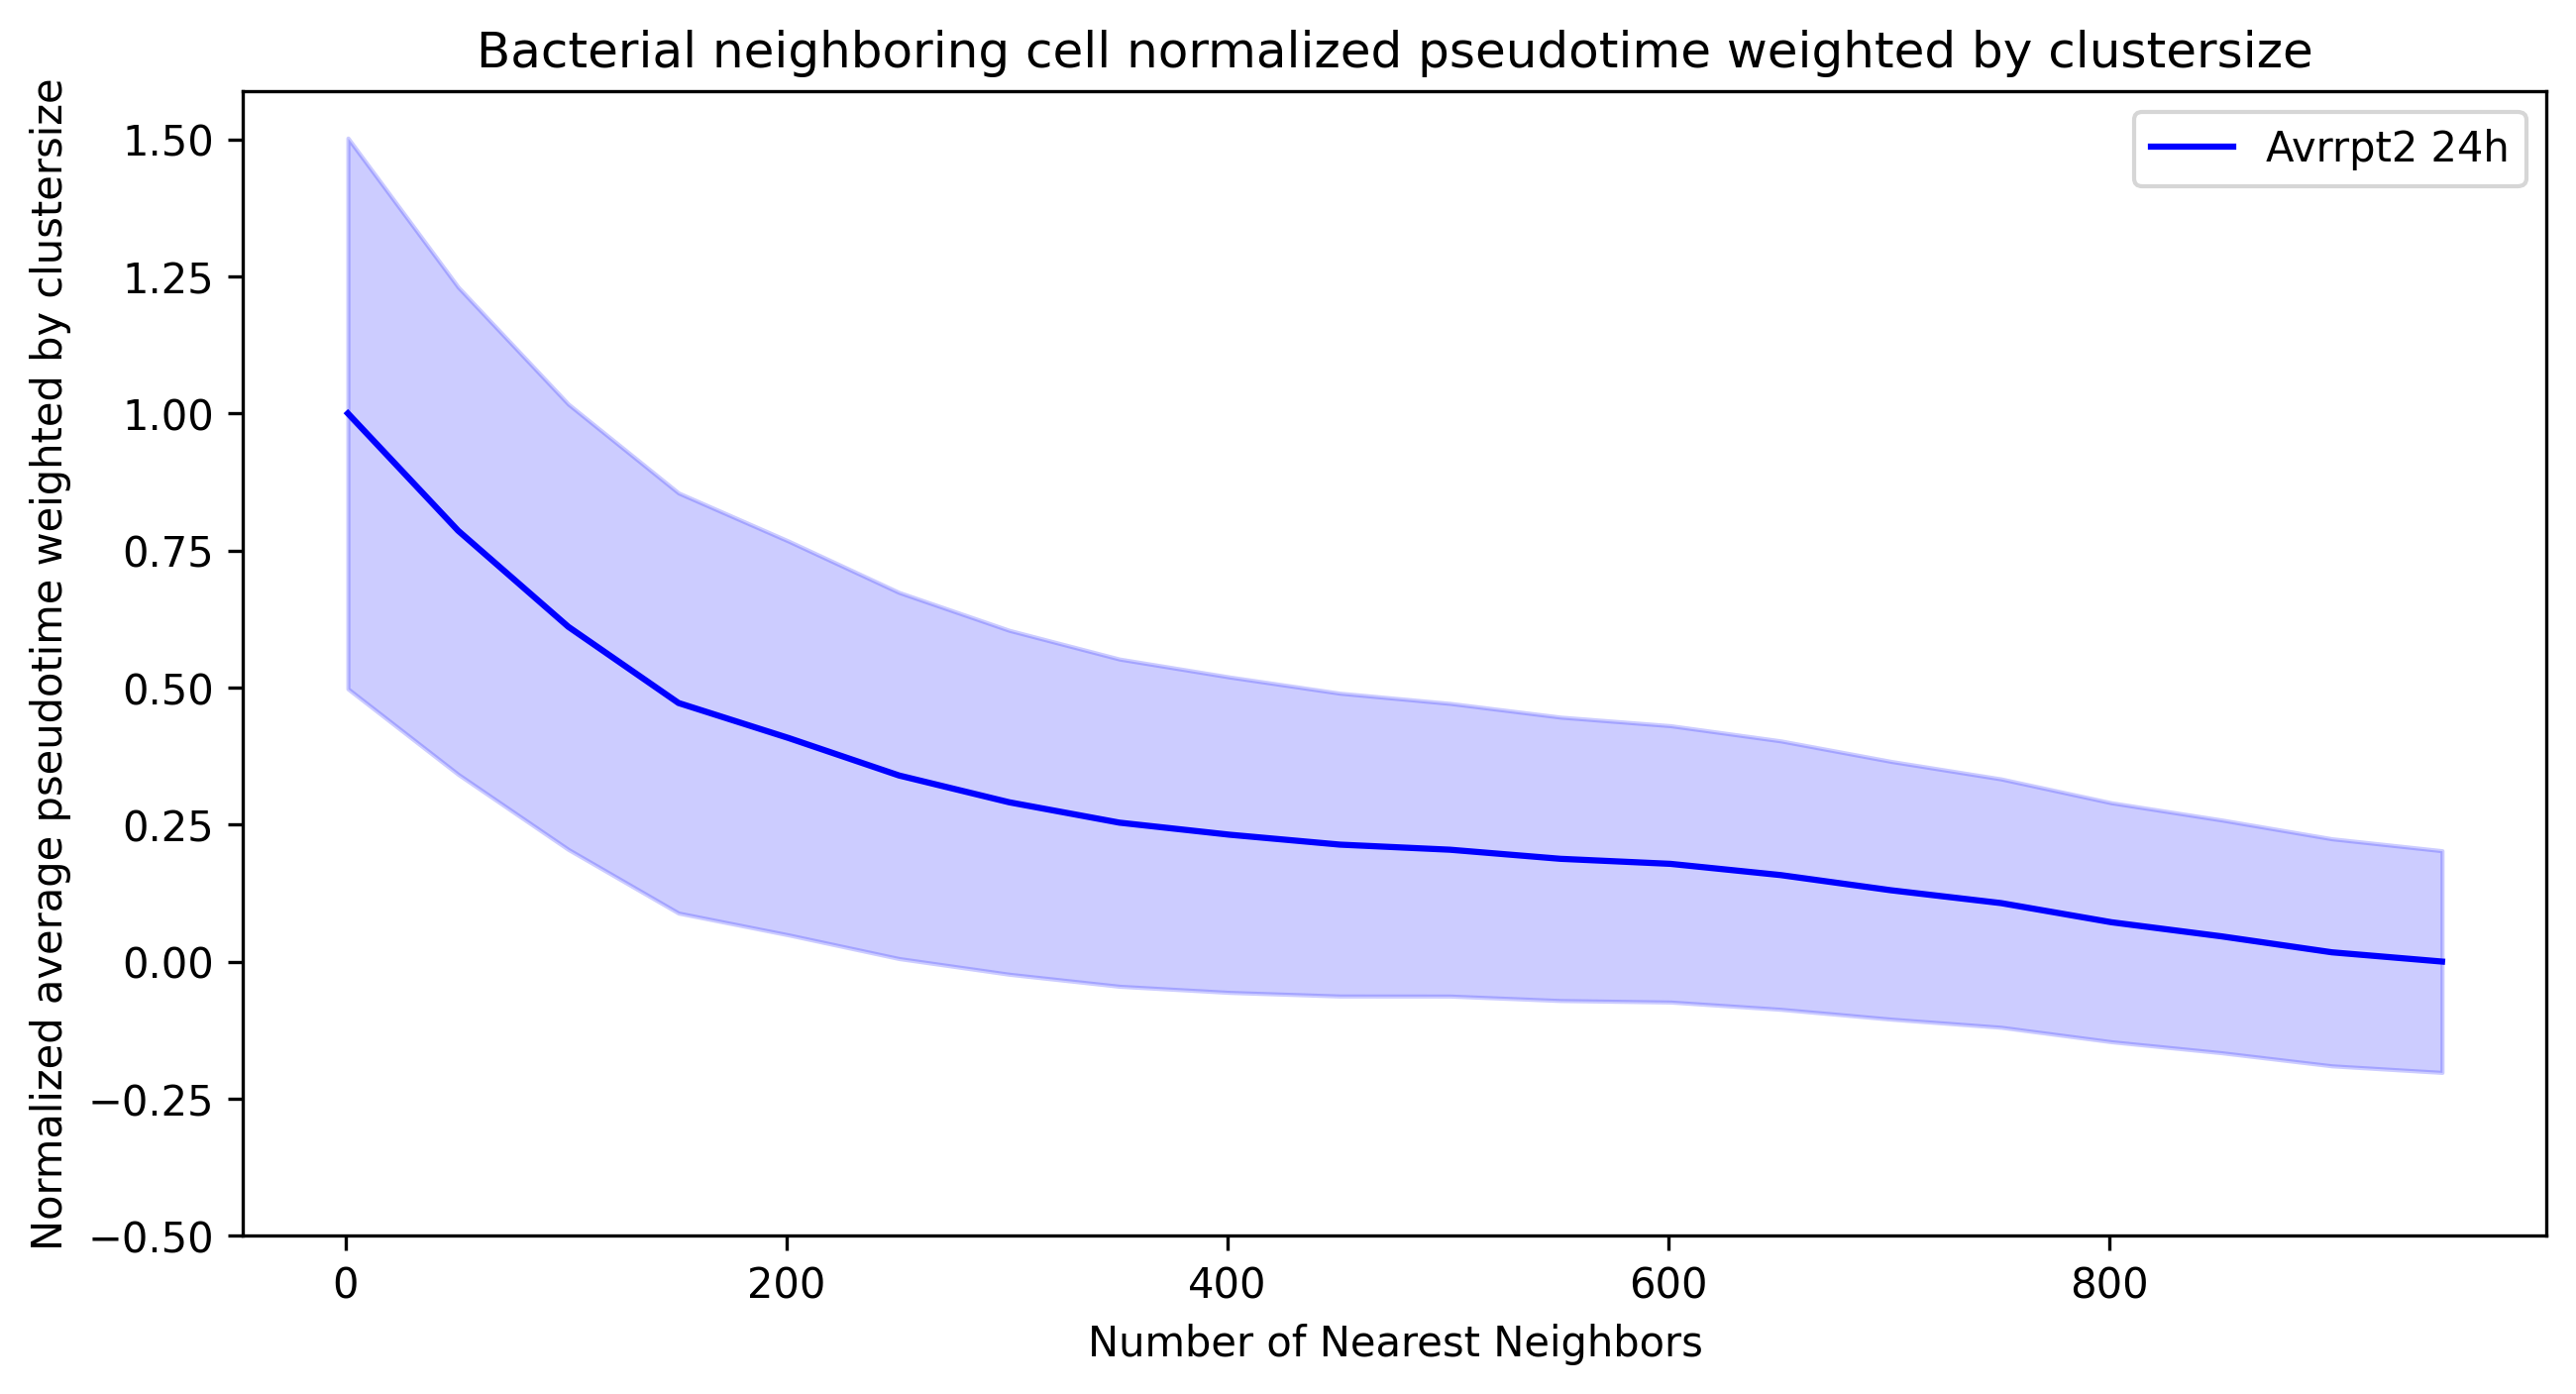

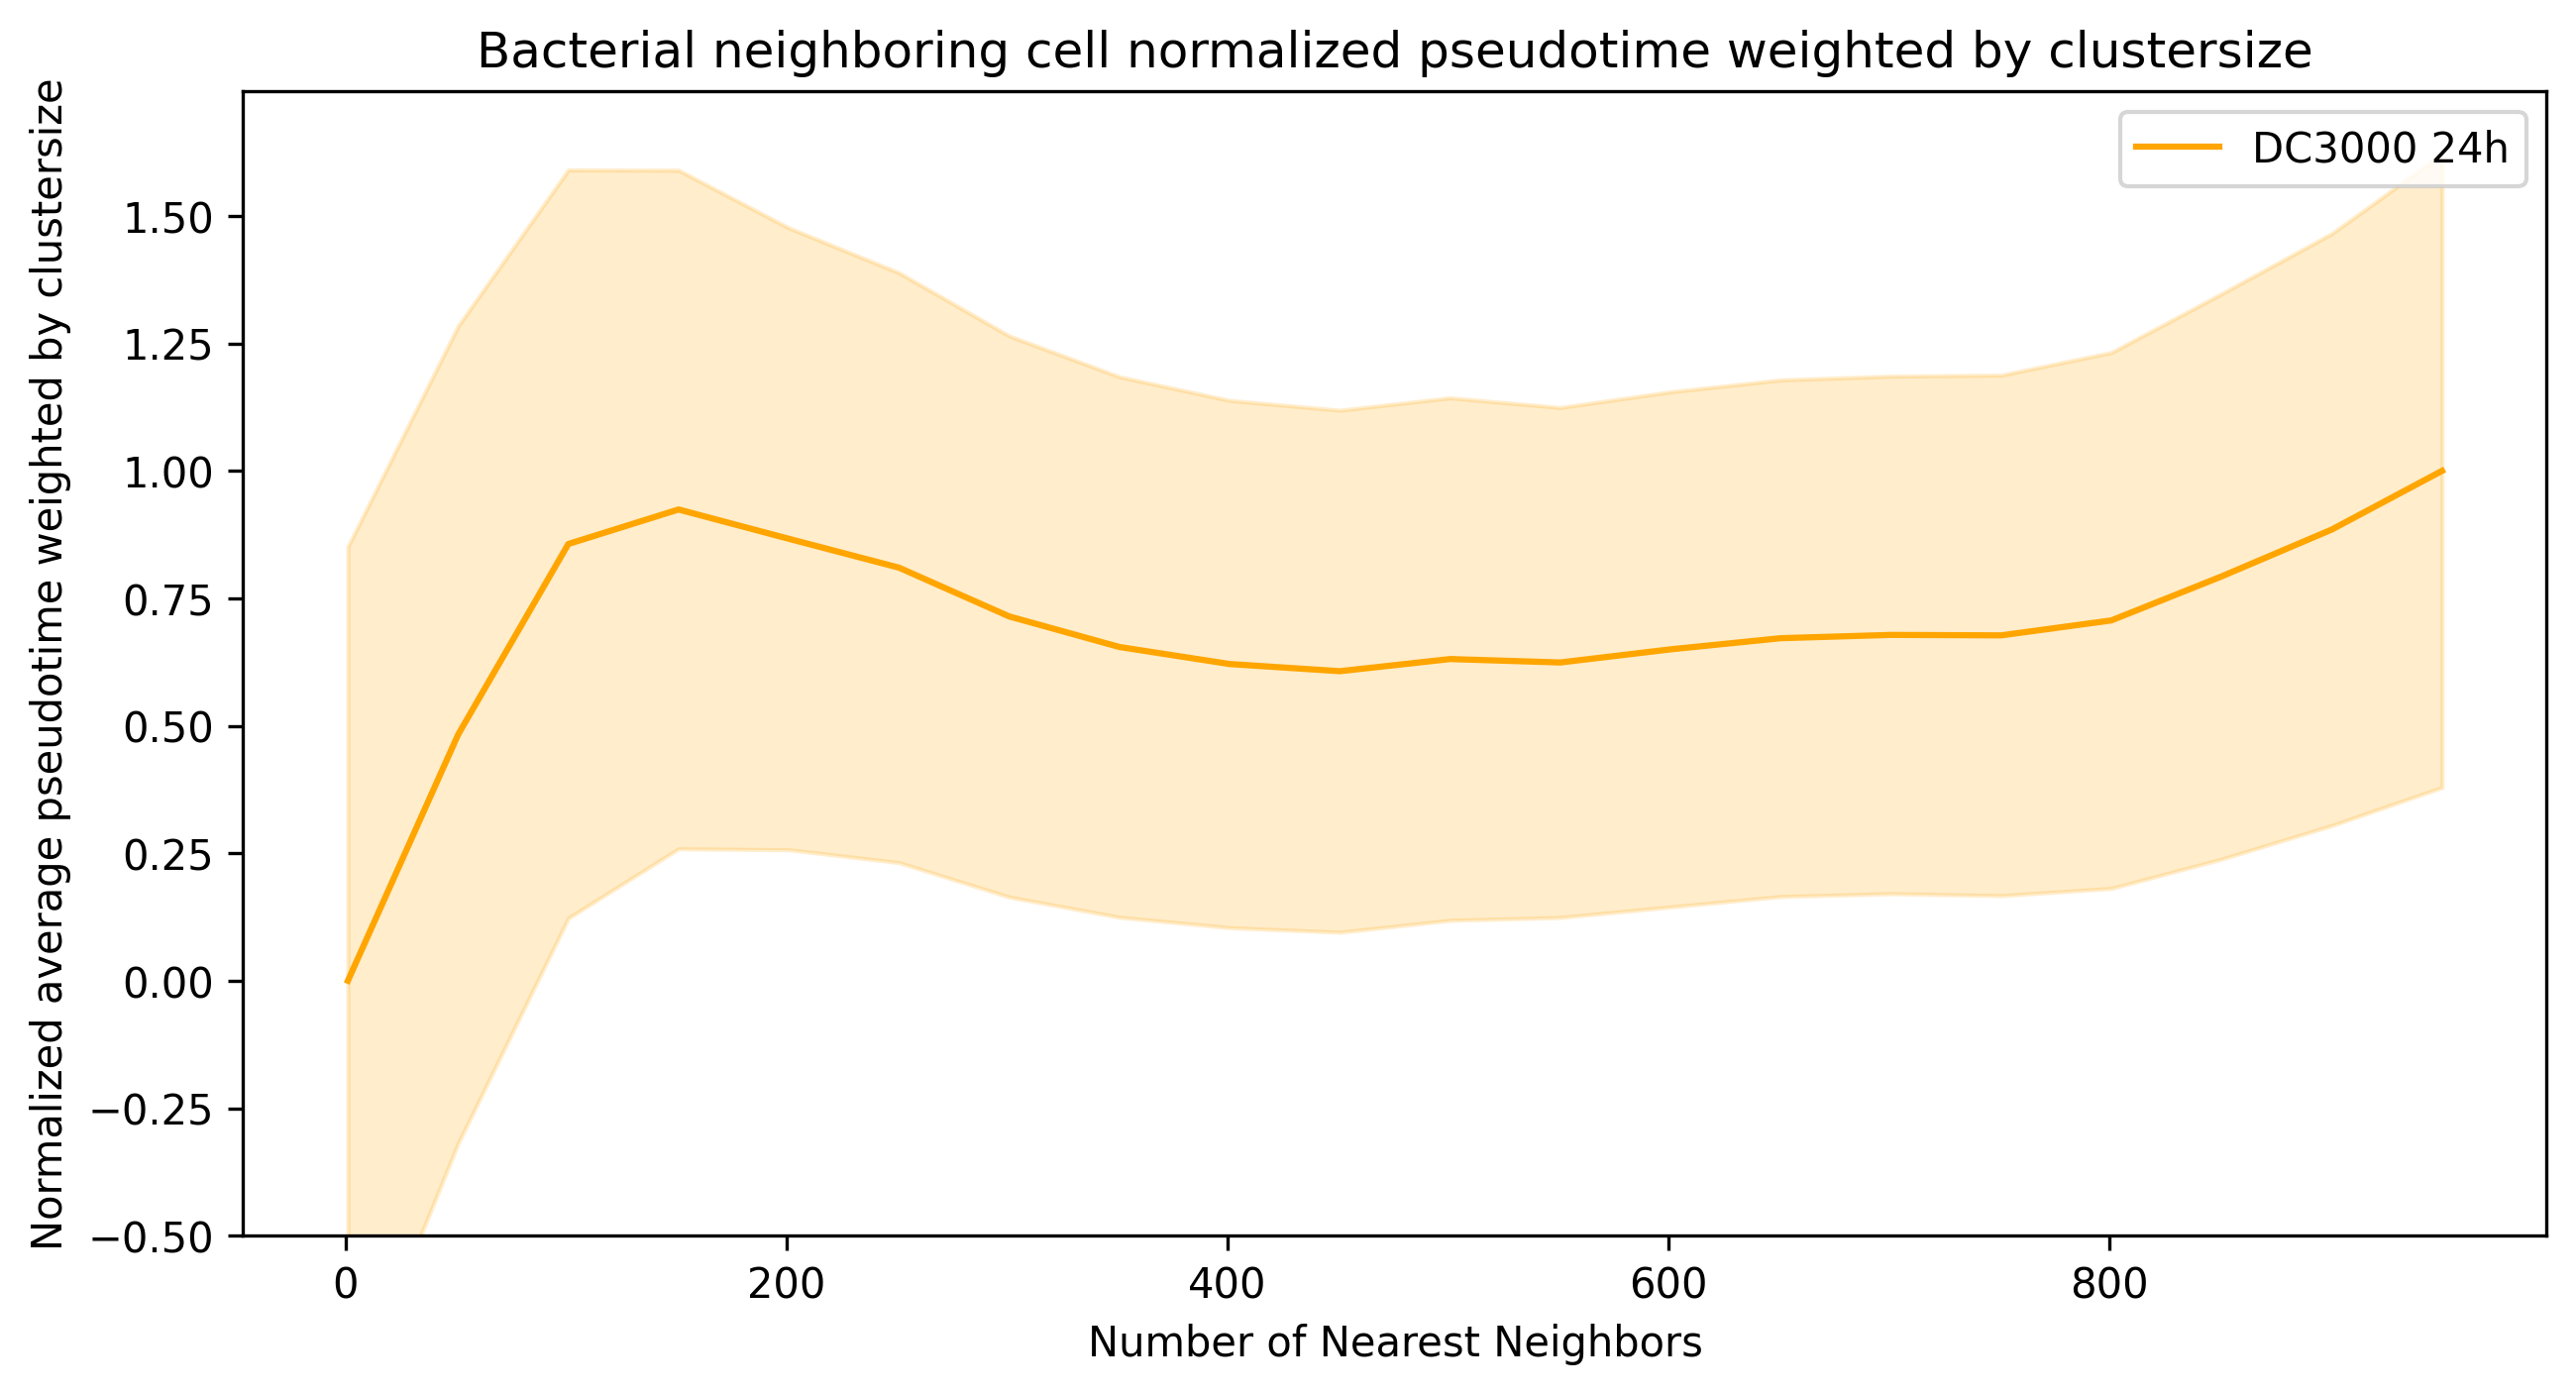

In [22]:

# Plot the normalized values
for k in range(len(mean_pseudo_weighted_by_clustersize)):
    plt.figure(figsize=(10, 5), dpi=300)


    plt.plot(arrange, mean_pseudo_weighted_by_clustersize[k], color=colors[k], label=sample_names[k])
    # Add normalized standard deviation
    plt.fill_between(arrange, mean_pseudo_weighted_by_clustersize[k] - std_pseudo_weighted_by_clustersize[k], mean_pseudo_weighted_by_clustersize[k] + std_pseudo_weighted_by_clustersize[k], color=colors[k], alpha=0.2)

    plt.xlabel('Number of Nearest Neighbors')
    plt.ylabel('Normalized average pseudotime weighted by clustersize')
    plt.title('Bacterial neighboring cell normalized pseudotime weighted by clustersize')
    plt.ylim(-.5, )
    plt.legend()
    plt.savefig(os.path.join(sample, f'pseudotime_weighted_by_clustersize_normalized.pdf'))
    plt.show()
    plt.close()

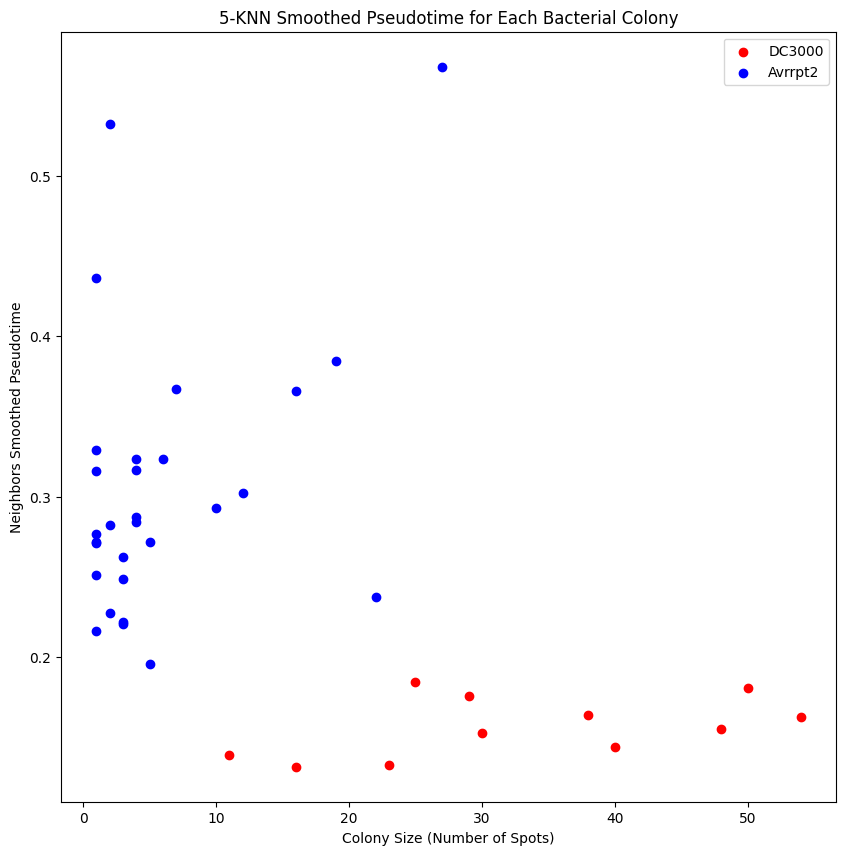

In [109]:
plt.figure(figsize=(10, 10))
plt.scatter(k5_cluster[1], k5_pseudo[1], color = 'red', label = 'DC3000')
plt.scatter(k5_cluster[0], k5_pseudo[0], color = 'blue', label = 'Avrrpt2')
plt.xlabel("Colony Size (Number of Spots)")
plt.ylabel("Neighbors Smoothed Pseudotime")
plt.title("5-KNN Smoothed Pseudotime for Each Bacterial Colony")
plt.legend()
plt.dpi = 300
plt.savefig(r'Colony_Pseudotime_Neighborhood.pdf')
plt.show()